# Models Comparison
Comparaison des scores des différentes expériences réalisées dans ce projet

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [91]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import geopandas as gpd

from keras.layers import LeakyReLU
from keras.models import load_model
from focal_loss import BinaryFocalLoss
from shapely import wkt
from sklearn.metrics import confusion_matrix, f1_score, classification_report, multilabel_confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics


from IAdeforestation.tools import *
from IAdeforestation.training import *

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [32]:
def set_model_prediction(model_path, test_set, custom_objects, with_f1=False, labels=["Coffee", "Other"], title="title"):
    test_generator =  generator(test_set['path'].to_numpy(), 
                            test_set['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(test_set))
    
    prediction_set = []
    evaluate = []
    
    X, y = next(test_generator)
    
    for path in os.listdir(model_path):
        if path.split(".")[1] == 'h5':
            restored_model = None
            if with_f1:
                restored_model = load_model(os.path.join(model_path, path), custom_objects, compile=False)
                restored_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',metrics=[metrics.BinaryAccuracy(name='accuracy'),metrics.Precision(name='precision'),metrics.Recall(name='recall'),f1_score_keras])
            else : 
                restored_model = load_model(os.path.join(model_path, path), custom_objects)
            
            evaluate.append(restored_model.evaluate(test_generator, steps=1))
            prediction_set.append(np.where(restored_model.predict(X) > 0.5, 1, 0).reshape(-1).tolist())
            
    predictions = []
    for pred in zip(*prediction_set):
        predictions.append(np.argmax(np.bincount(pred)))
    
    cm = confusion_matrix(y, predictions)
    plot_confusion_matrix(cm, labels,title)
    
    if with_f1:
        losses, accs, precisions, recalls, f1 = zip(*evaluate)
    else :
        losses, accs, precisions, recalls = zip(*evaluate)

    print(f"Mean accuracy : {np.mean(accs)}")
    print(f"Stdev accuracy : {np.std(accs)}")
    print("\n")
    print(f"Mean loss : {np.mean(losses)}")
    print(f"Stdev loss : {np.std(losses)}")
    print("\n")
    print(f"Mean precision : {np.mean(precisions)}")
    print(f"Stdev precision : {np.std(precisions)}")
    print("\n")
    print(f"Mean recall : {np.mean(recalls)}")
    print(f"Stdev recall : {np.std(recalls)}")
    print("\n")
    if with_f1:
        print(f"Mean f1-score : {np.mean(f1)}")
        print(f"Stdev f1-score : {np.std(f1)}")
    else:
        print(f"F1-Score : {f1_score(y, predictions)}")
    print(f"Macro F1-Score : {f1_score(y, predictions, average='macro')}")

# Path definition

In [51]:
SAVED_MODELS_PATH = os.path.join('saved_models')
TENSORFLOW_HUB_PATH = os.path.join('tensowflow_hub')
TRANSFER_LEARNING_PATH = os.path.join('transfer_learning')
FROM_SCRATCH_PATH = os.path.join('from_scratch')
FINE_TUNING_PATH = os.path.join('all_layers_unfreeze')
MULTI_LABEL_PATH = os.path.join('multi_label')

# Coffee - Startified dataset

In [34]:
paths = {
    'ResNet 64x64':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Coffee','strat_coffee_2', 'strat_coffee_2.json'),
    'ResNet 32x32':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Coffee','strat_coffee_32_1', 'strat_coffee_32_1.json'),
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_2', 'start_coffee_2.json'),
    'DenseNet 32x32':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','strat_coffee_32_1', 'strat_coffee_32_1.json'),
    'DenseNet 64x64 \nVietnam params':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_vietnam_2', 'start_coffee_vietnam_2.json'),
    'DenseNet 32x32 \nVietnam params':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_vietnam_32_1', 'start_coffee_vietnam_32_1.json'),
    'DenseNet 64x64 \n300 epochs\nFocal loss':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_300E_focal_2', 'start_coffee_300E_focal_2.json'),
}

## Boxplots

In [35]:
epochs_accs = []
epochs_f1 = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        epochs_accs.append(list(zip(*data))[1])
        epochs_f1.append(list(zip(*data))[4])
        epochs_loss.append(list(zip(*data))[0])


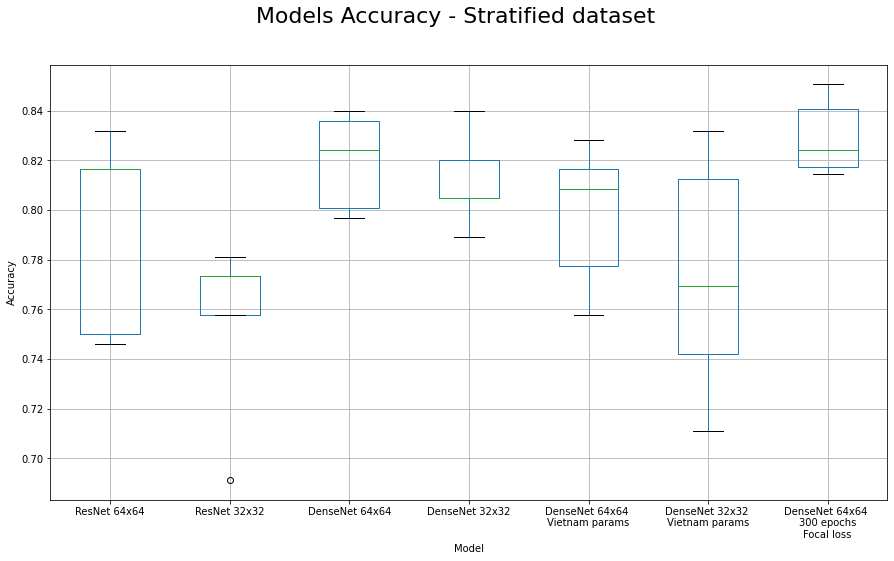

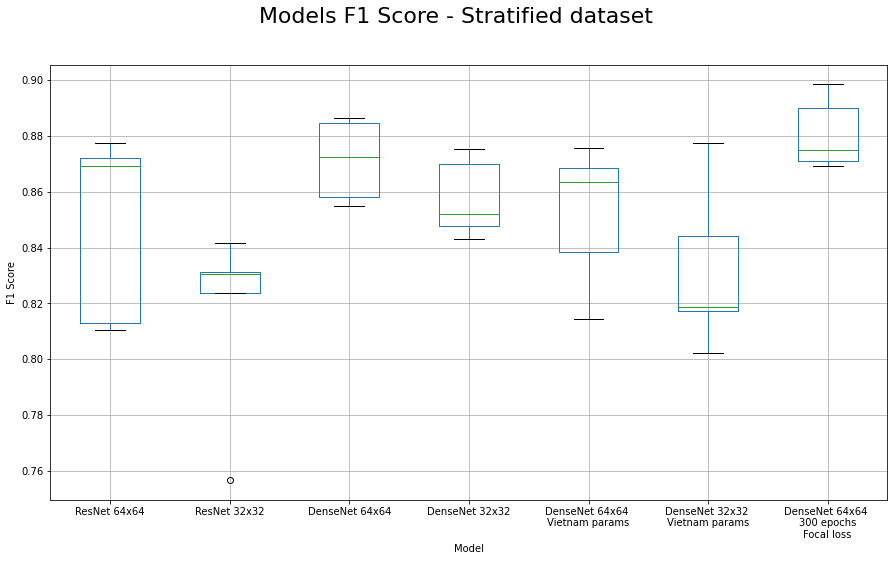

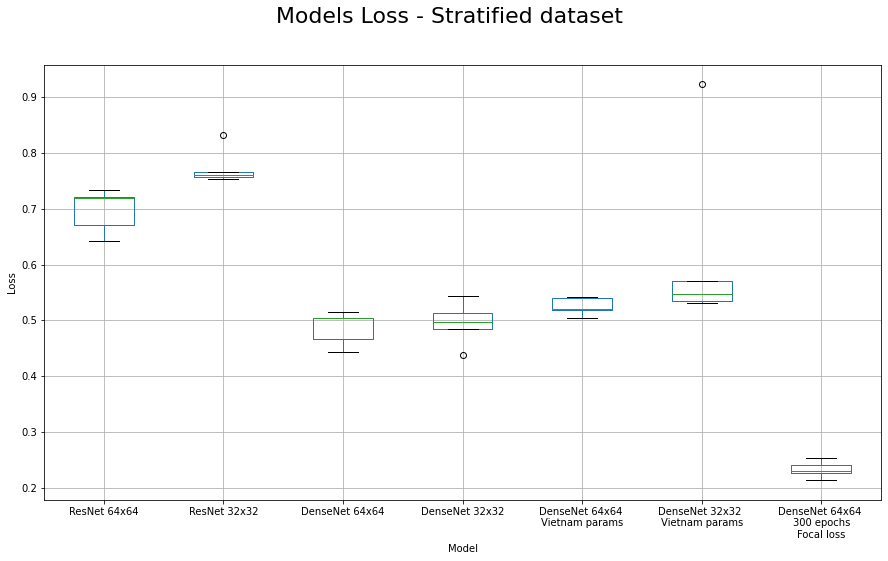

In [36]:
dict_metrics = {'Accuracy':epochs_accs, 'F1 Score':epochs_f1, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric} - Stratified dataset", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

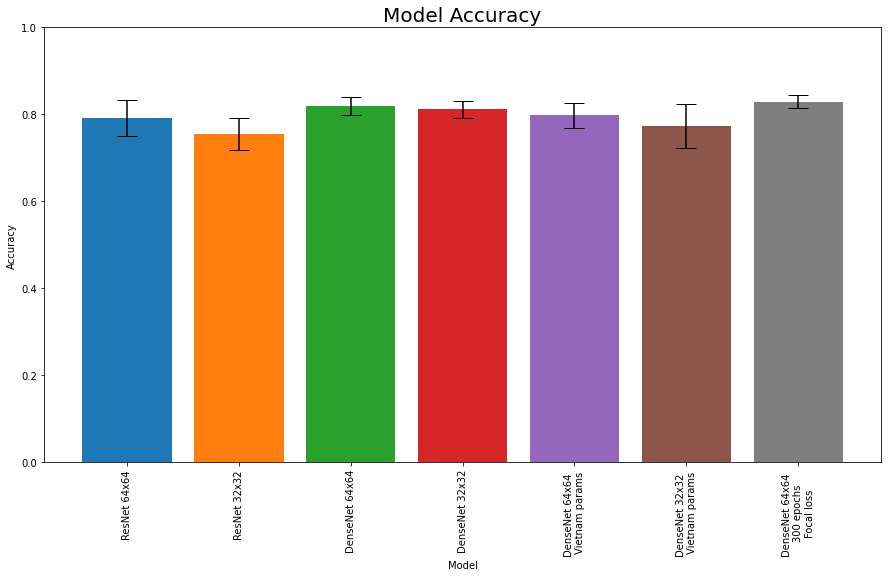

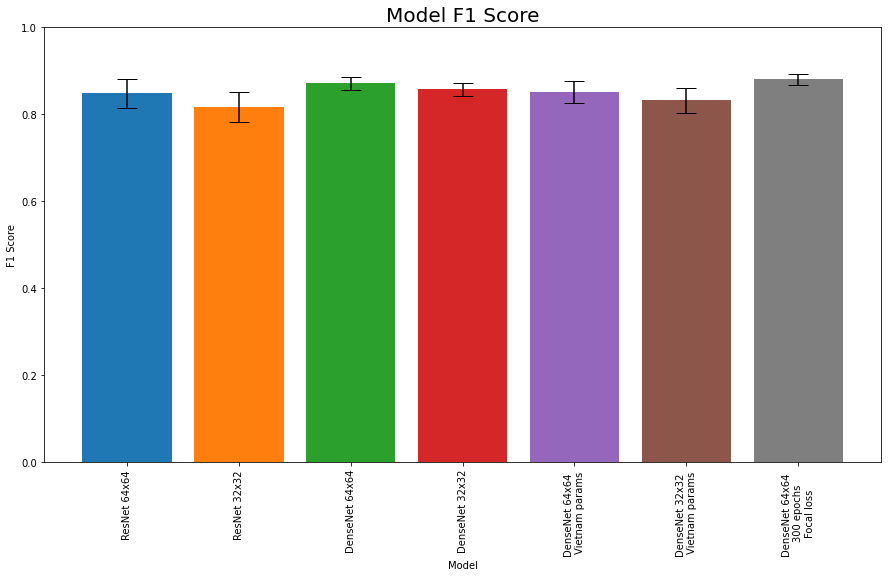

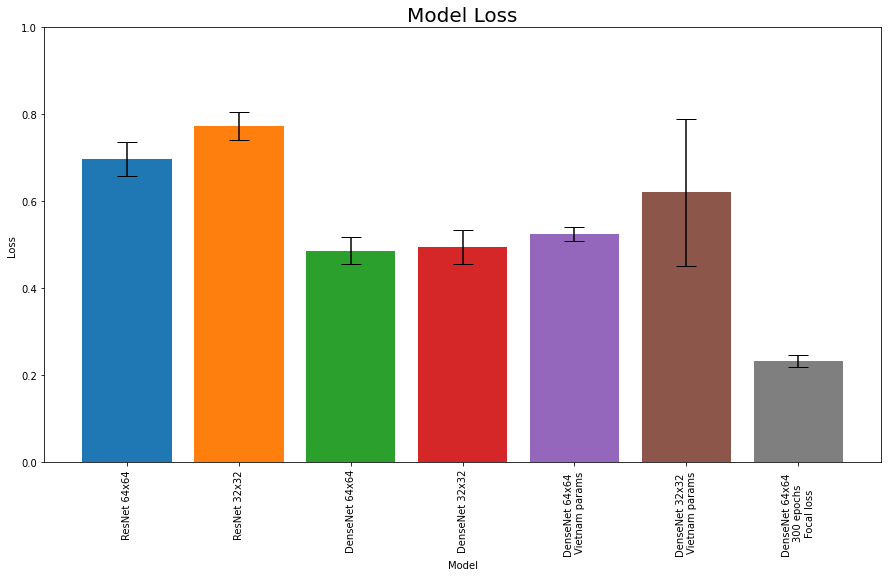

In [37]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:gray'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [40]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 3s 3s/step - loss: 0.4489 - accuracy: 0.8426 - precision: 0.9460 - recall: 0.8403
Mean accuracy : 0.8353510856628418
Stdev accuracy : 0.01114854553212761


Mean loss : 0.4627214550971985
Stdev loss : 0.012169151044349822


Mean precision : 0.9550374865531921
Stdev precision : 0.00909217162003758


Mean recall : 0.8217252373695374
Stdev recall : 0.022985450645795973


F1-Score : 0.8911564625850341
Macro F1-Score : 0.8111244497799119


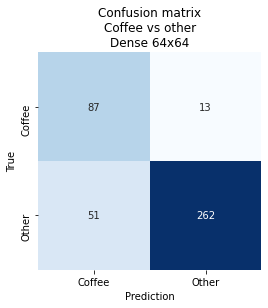

In [41]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                    title="Confusion matrix\nCoffee vs other\nDense 64x64")

### DenseNet 64x64 300 epochs Focal loss

1/1 [==============================] - 2s 2s/step - loss: 0.2277 - accuracy: 0.8184 - precision: 0.9343 - recall: 0.8179
Mean accuracy : 0.8222760200500489
Stdev accuracy : 0.012867151484359613


Mean loss : 0.23093397915363312
Stdev loss : 0.012601269847336193


Mean precision : 0.9386393904685975
Stdev precision : 0.007291659604796355


Mean recall : 0.8191693305969239
Stdev recall : 0.02006431482476695


F1-Score : 0.8779661016949153
Macro F1-Score : 0.7864406779661017


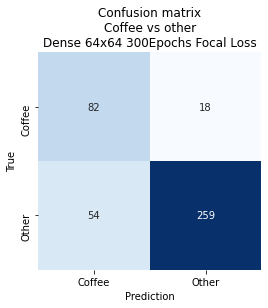

In [42]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_300E_focal_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                    title="Confusion matrix\nCoffee vs other\nDense 64x64 300Epochs Focal Loss")

# Culture - Stratified dataset

In [43]:
paths = {
    'ResNet 64x64':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Culture','strat_culture_1', 'strat_culture_1.json'),
    'ResNet 32x32':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Culture','strat_culture_32_1', 'strat_culture_32_1.json'),
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','strat_culture_1', 'strat_culture_1.json'),
    'DenseNet 32x32':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','strat_culture_32_c1', 'strat_culture_32_c1.json')
}

In [44]:
epochs_accs = []
epochs_f1 = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        epochs_accs.append(list(zip(*data))[1])
        epochs_f1.append(list(zip(*data))[4])
        epochs_loss.append(list(zip(*data))[0])


## Boxplot

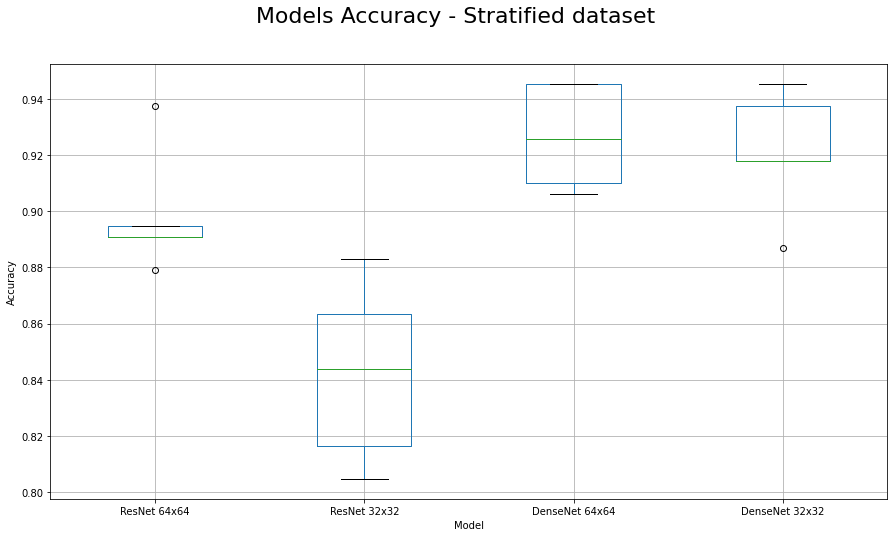

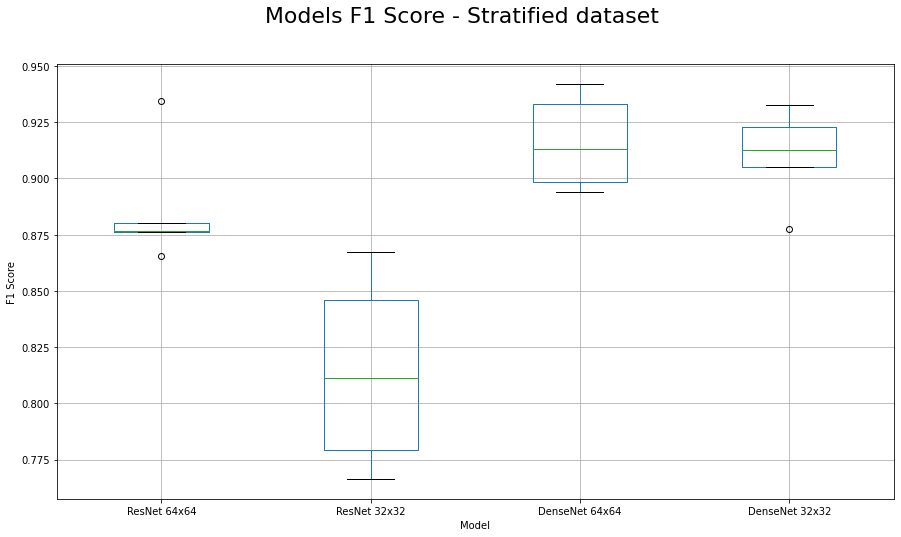

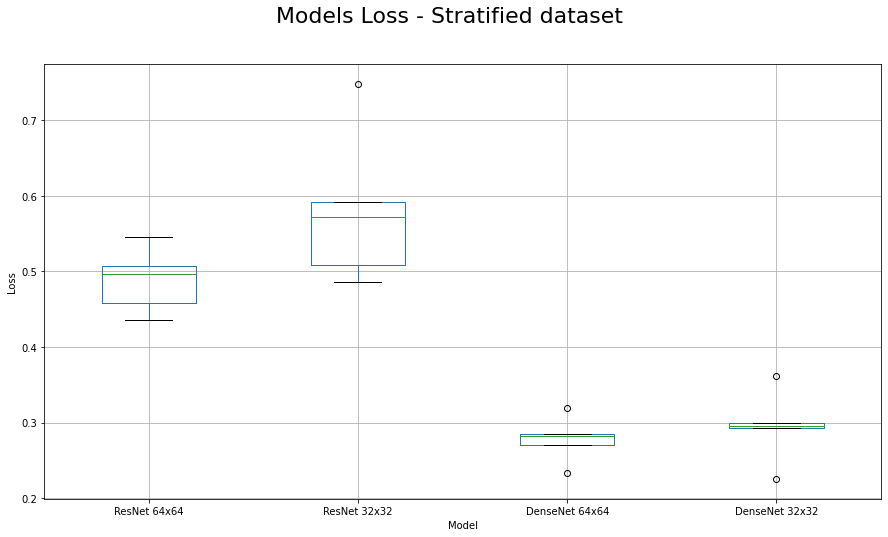

In [45]:
dict_metrics = {'Accuracy':epochs_accs, 'F1 Score':epochs_f1, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric} - Stratified dataset", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

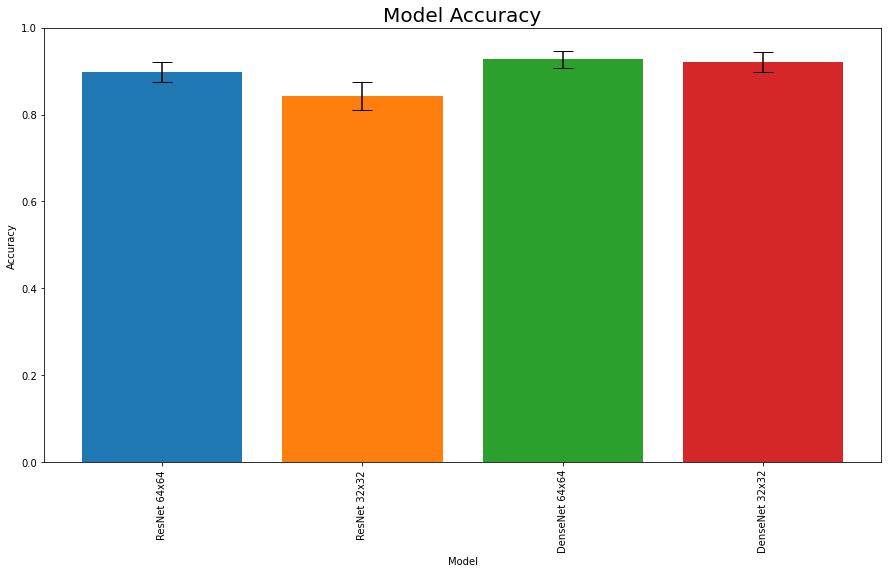

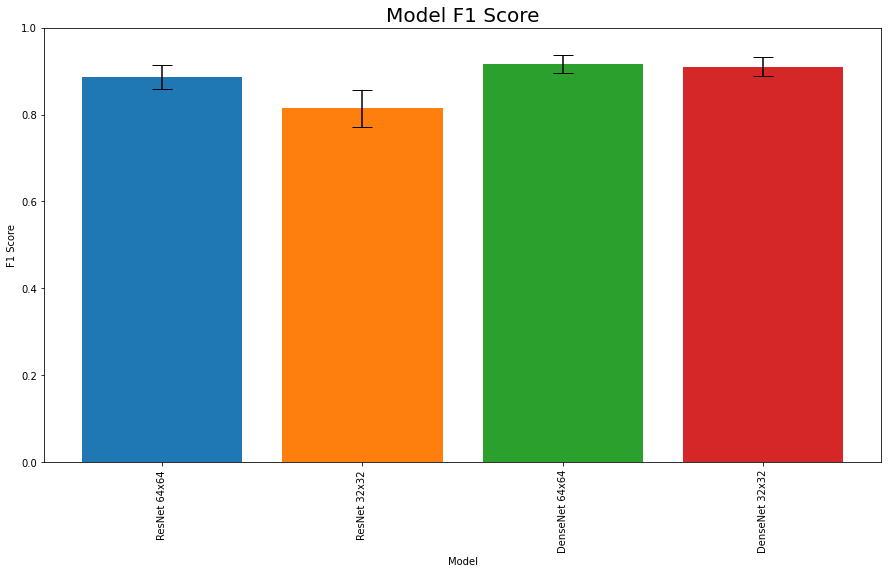

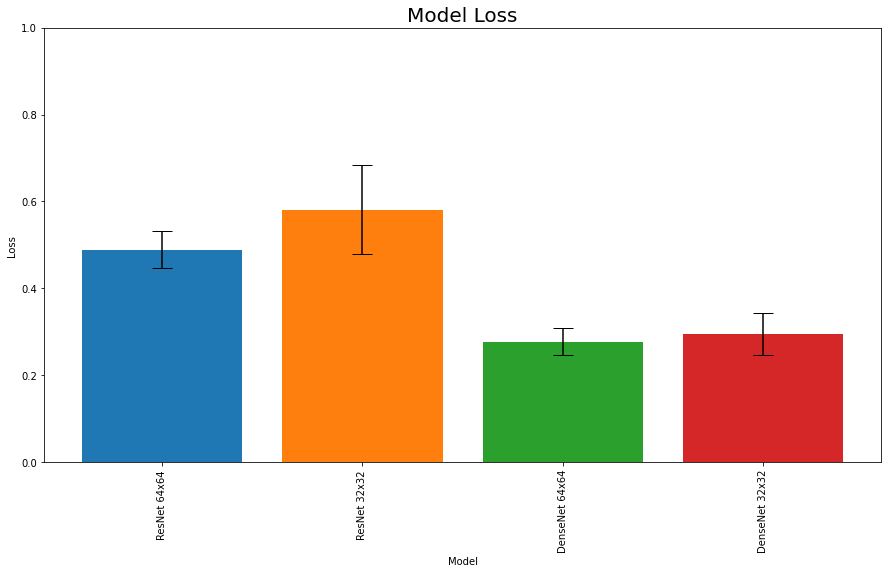

In [46]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [47]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_test_culture.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64

1/1 [==============================] - 2s 2s/step - loss: 0.3354 - accuracy: 0.9067 - precision: 0.9490 - recall: 0.8466
Mean accuracy : 0.9205333352088928
Stdev accuracy : 0.009891848495272233


Mean loss : 0.2934987246990204
Stdev loss : 0.024394767728400216


Mean precision : 0.9540772080421448
Stdev precision : 0.010659066481529273


Mean recall : 0.8727272748947144
Stdev recall : 0.015497918966593464


F1-Score : 0.9161676646706587
Macro F1-Score : 0.9244299861814833


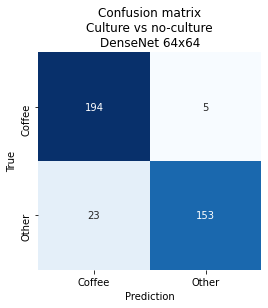

In [48]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','strat_culture_1'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                    title="Confusion matrix\nCulture vs no-culture\nDenseNet 64x64")

# Coffee - Spatial Cross val

In [52]:
paths = {
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_1', 'final_spacv_10FOLD_coffee_1.json'),
    'DenseNet 32x32':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_32_1', 'final_spacv_10FOLD_coffee_32_1.json'),
    'DenseNet 64x64\nFrom scratch':os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Coffee','final_spacv_10FOLD_coffee2', 'final_spacv_10FOLD_coffee2.json'),
    'DenseNet 32x32\nFrom scratch':os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Coffee','final_spacv_10FOLD_coffee_32_1', 'final_spacv_10FOLD_coffee_32_1.json'),
    'DenseNet 64x64 Fine-tuning':os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_finetuning_3', 'final_spacv_10FOLD_coffee_finetuning_3.json'),
}

## Boxplot

In [53]:
epochs_accs = []
epochs_f1 = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        metrics = list(zip(*data))
        
        epochs_loss.append(metrics[0])
        epochs_accs.append(metrics[1])

        if len(metrics) > 4:
            epochs_f1.append(metrics[4])
        else:
            tmp = []
            for i in range(0,len(metrics[2])):
                tmp.append(2*((metrics[2][i]*metrics[3][i]) / (metrics[2][i]+metrics[3][i])))
            epochs_f1.append(tmp)
        


### Boxplot

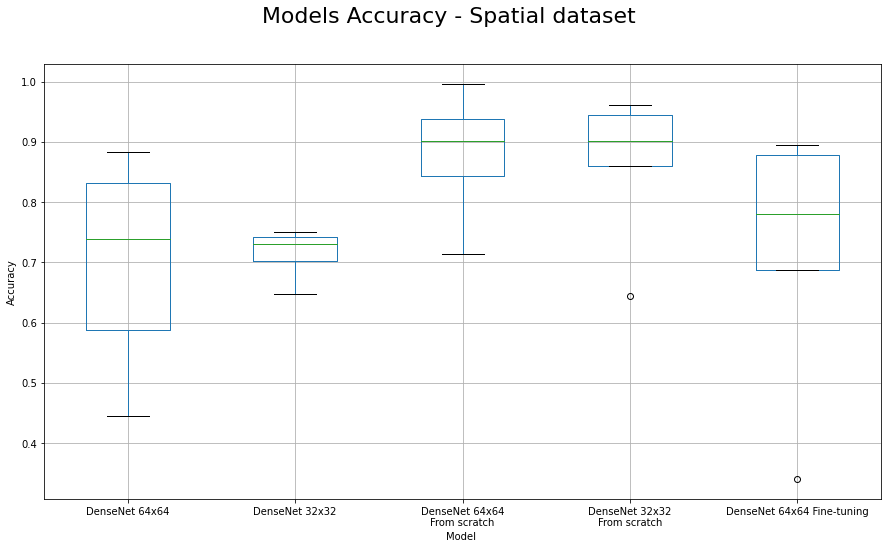

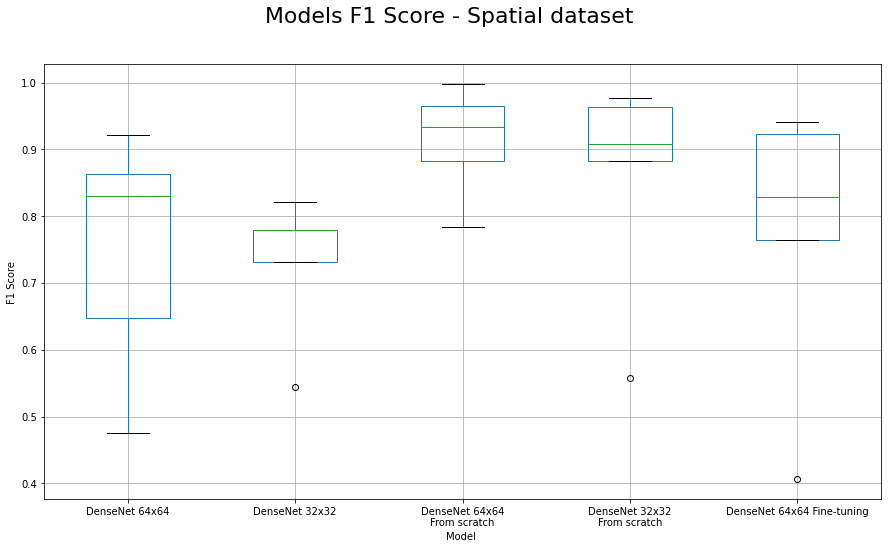

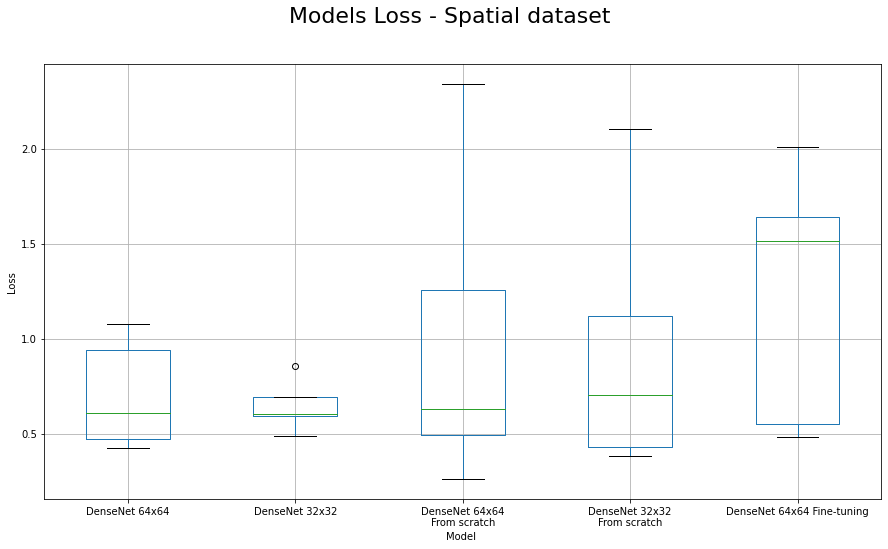

In [54]:
dict_metrics = {'Accuracy':epochs_accs, 'F1 Score':epochs_f1, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric} - Spatial dataset", fontsize=22)
    
    ax.set_xlabel("Model ")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

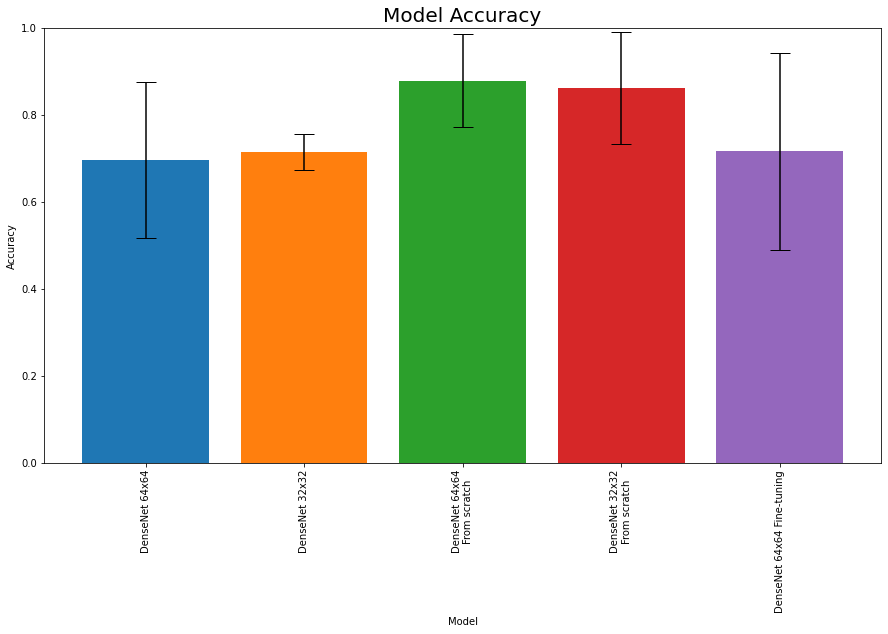

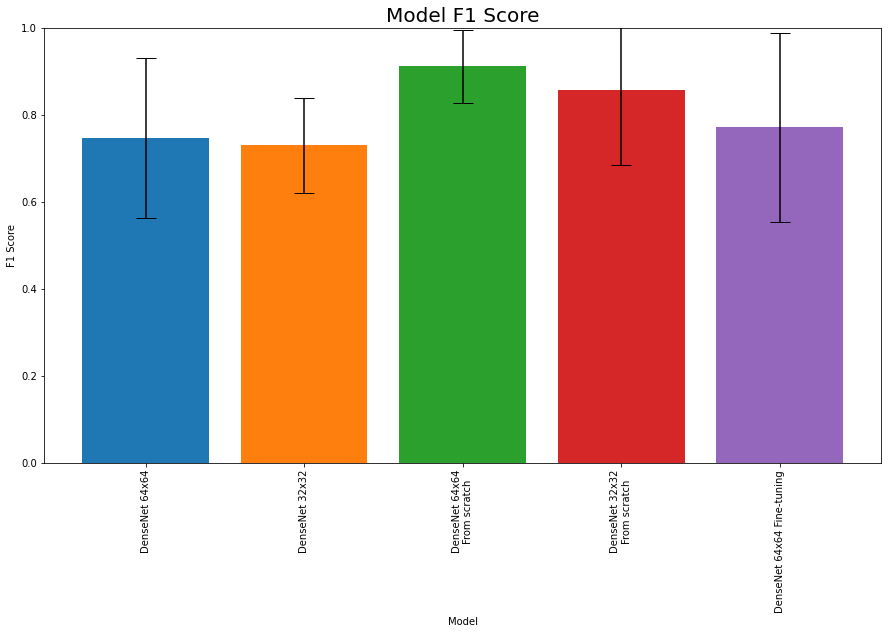

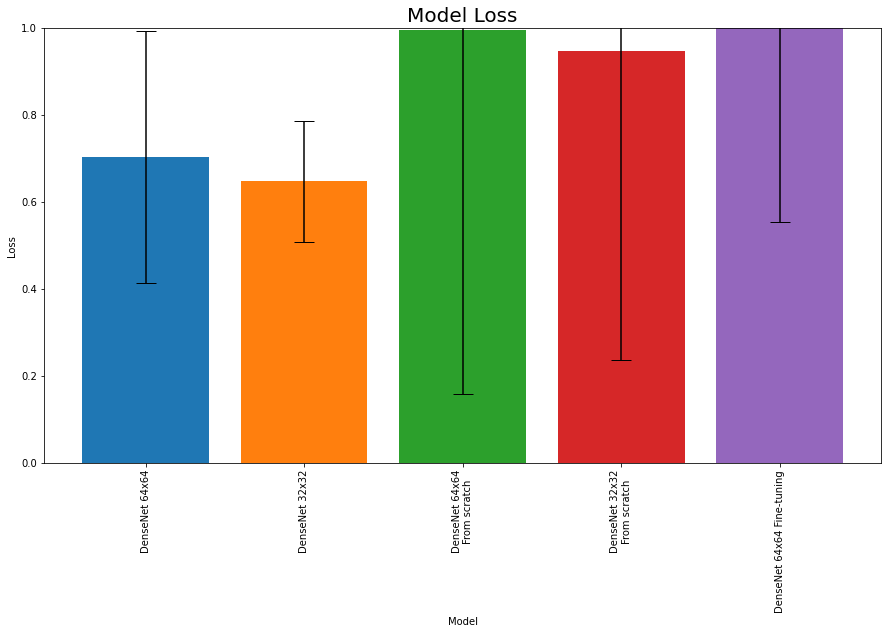

In [55]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [59]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold','test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 4s 4s/step - loss: 0.9646 - accuracy: 0.6010 - precision: 0.9474 - recall: 0.5176 - f1_score_keras: 0.6694
Mean accuracy : 0.51670823097229
Stdev accuracy : 0.09393786889869259


Mean loss : 1.2647241353988647
Stdev loss : 0.3967572856704704


Mean precision : 0.8814450383186341
Stdev precision : 0.07636098528182579


Mean recall : 0.4319488763809204
Stdev recall : 0.10230428685138195


Mean f1-score : 0.5760307371616363
Stdev f1-score : 0.11380578836520248
Macro F1-Score : 0.5327152744245935


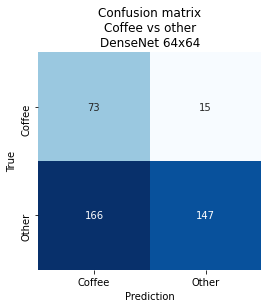

In [60]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                    title="Confusion matrix\nCoffee vs other\nDenseNet 64x64")

### DenseNet 64x64 From Scratch

1/1 [==============================] - 4s 4s/step - loss: 7.4802 - accuracy: 0.2344 - precision: 0.5227 - recall: 0.2204 - f1_score_keras: 0.3101
Mean accuracy : 0.32119700610637664
Stdev accuracy : 0.062481642502185734


Mean loss : 7.493364334106445
Stdev loss : 0.9510666958139461


Mean precision : 0.6209598898887634
Stdev precision : 0.07064925616266675


Mean recall : 0.321405753493309
Stdev recall : 0.07309524881251502


Mean f1-score : 0.421579110622406
Stdev f1-score : 0.07752966482715955
Macro F1-Score : 0.2726535967891325


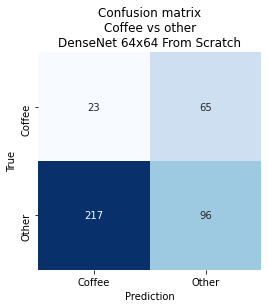

In [61]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Coffee','final_spacv_10FOLD_coffee1'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                    title="Confusion matrix\nCoffee vs other\nDenseNet 64x64 From Scratch")

### DenseNet 64x64 Fine tuning

1/1 [==============================] - 4s 4s/step - loss: 1.5468 - accuracy: 0.6783 - precision: 0.9000 - recall: 0.6613 - f1_score_keras: 0.7624
Mean accuracy : 0.6014962673187256
Stdev accuracy : 0.11381410516429254


Mean loss : 2.5616528511047365
Stdev loss : 1.7242919724895602


Mean precision : 0.8486209034919738
Stdev precision : 0.03964628712689322


Mean recall : 0.5897763550281525
Stdev recall : 0.1550834432796643


Mean f1-score : 0.6848324000835418
Stdev f1-score : 0.13445670515150976
Macro F1-Score : 0.5918575063613232


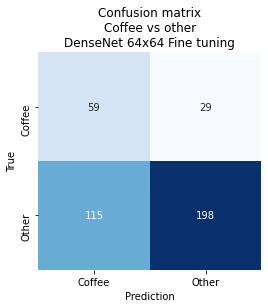

In [62]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_finetuning_3'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                    title="Confusion matrix\nCoffee vs other\nDenseNet 64x64 Fine tuning")

# Culture - Spatial Cross val

In [71]:
paths = {
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','final_spacv_10FOLD_culture_2', 'final_spacv_10FOLD_culture_ds2.json'),
    'DenseNet 64x64\nFrom scratch':os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Culture','final_spacv_10FOLD_culture_1', 'final_spacv_10FOLD_culture_ds2.json'),
    'DenseNet 64x64\nFine tuning':os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Culture','final_spacv_10FOLD_culture_finetuning_2', 'final_spacv_10FOLD_culture_finetuning_2.json')
}

## Boxplot

In [72]:
epochs_accs = []
epochs_f1 = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        metrics = list(zip(*data))
        
        epochs_loss.append(metrics[0])
        epochs_accs.append(metrics[1])

        if len(metrics) > 4:
            epochs_f1.append(metrics[4])
        else:
            tmp = []
            for i in range(0,len(metrics[2])):
                tmp.append(2*((metrics[2][i]*metrics[3][i]) / (metrics[2][i]+metrics[3][i])))
            epochs_f1.append(tmp)
        


### Boxplot

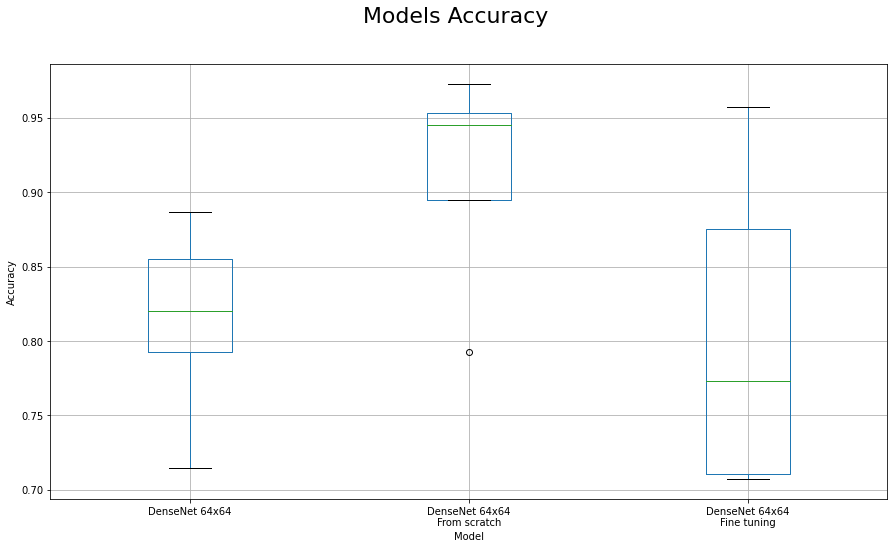

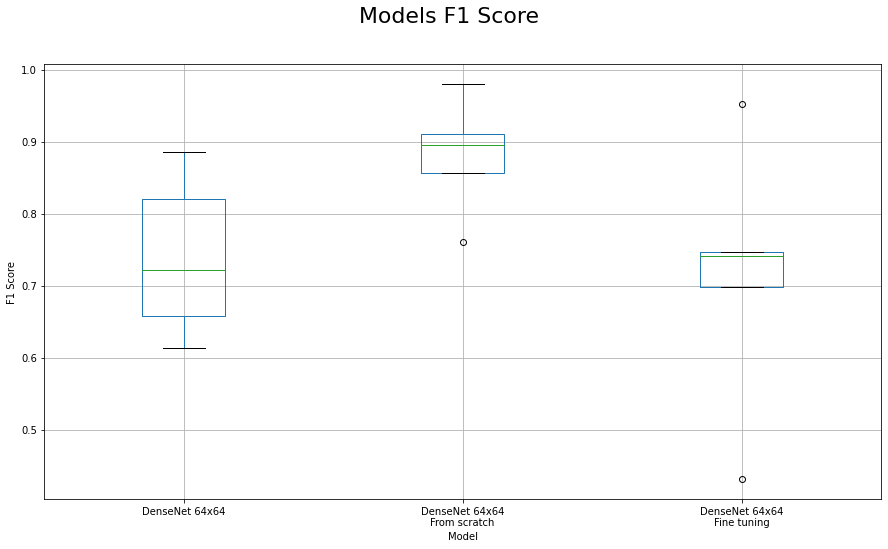

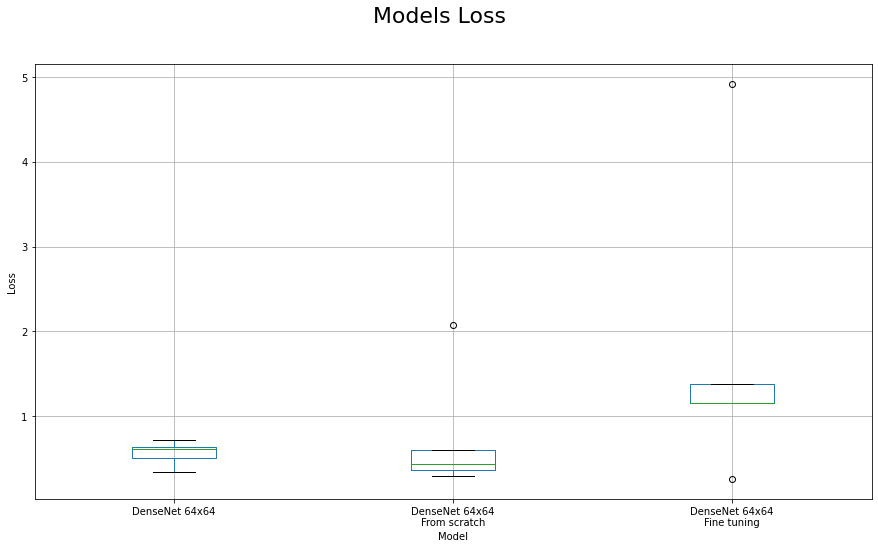

In [73]:
dict_metrics = {'Accuracy':epochs_accs, 'F1 Score':epochs_f1, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric}", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

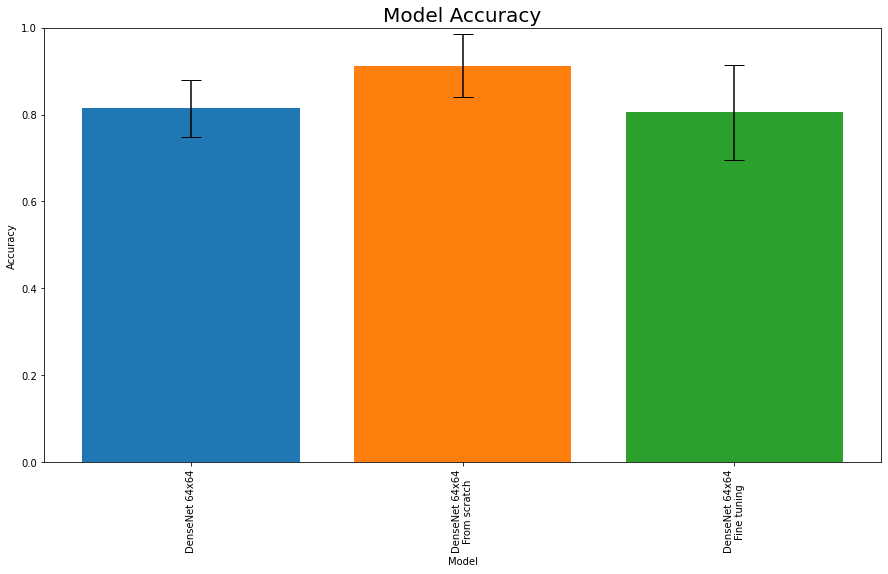

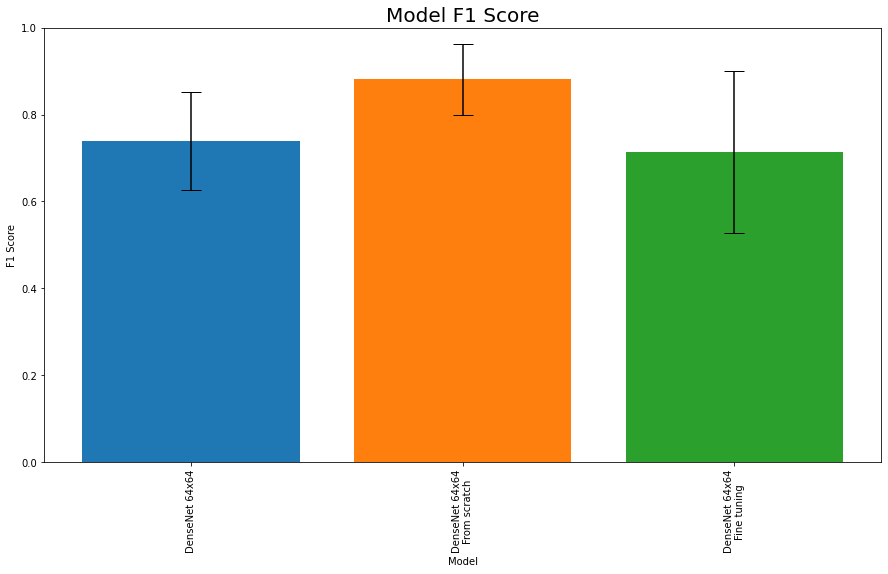

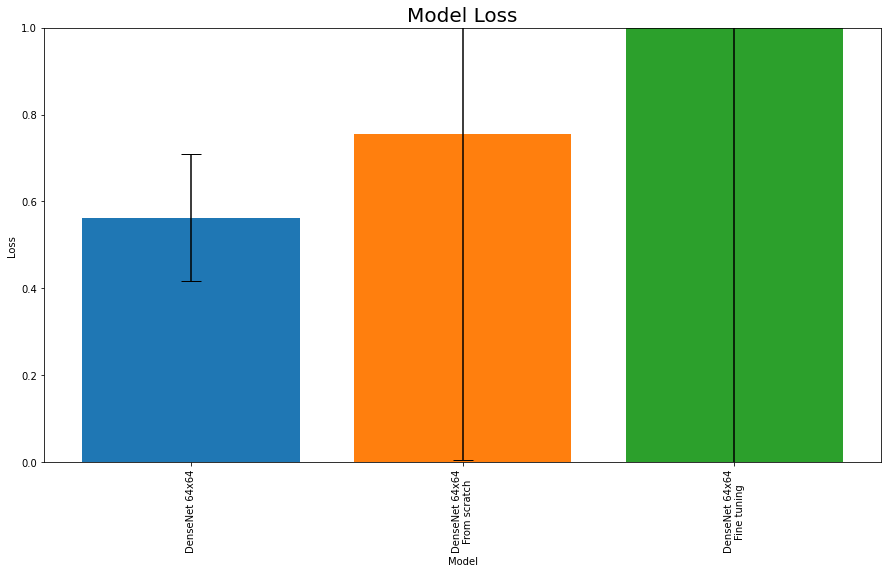

In [74]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [80]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'culture_10fold','test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 4s 4s/step - loss: 0.3023 - accuracy: 0.9029 - precision: 0.9359 - recall: 0.8975 - f1_score_keras: 0.9163
Mean accuracy : 0.9048543691635131
Stdev accuracy : 0.013764520765662817


Mean loss : 0.33038058280944826
Stdev loss : 0.049009419911651524


Mean precision : 0.9471988797187805
Stdev precision : 0.020716465643135253


Mean recall : 0.8893442630767823
Stdev recall : 0.010038899887968257


Mean f1-score : 0.9172322869300842
Stdev f1-score : 0.01147016079002122
Macro F1-Score : 0.9182259432345139


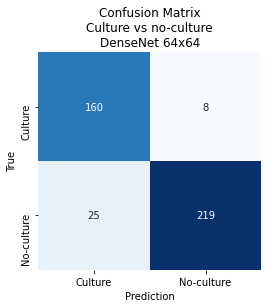

In [81]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','final_spacv_10FOLD_culture_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     labels=['Culture', 'No-culture'],
                     with_f1=True,
                     title="Confusion Matrix\nCulture vs no-culture\nDenseNet 64x64")

### DenseNet 64x64 From Scratch

1/1 [==============================] - 4s 4s/step - loss: 0.5864 - accuracy: 0.8981 - precision: 0.9509 - recall: 0.8730 - f1_score_keras: 0.9103
Mean accuracy : 0.874271833896637
Stdev accuracy : 0.025335903065220072


Mean loss : 0.9107035398483276
Stdev loss : 0.31003538646032225


Mean precision : 0.9354926347732544
Stdev precision : 0.022125552811529944


Mean recall : 0.8467212915420532
Stdev recall : 0.04357388921343236


Mean f1-score : 0.8881141185760498
Stdev f1-score : 0.025024531532058816
Macro F1-Score : 0.8840027555635427


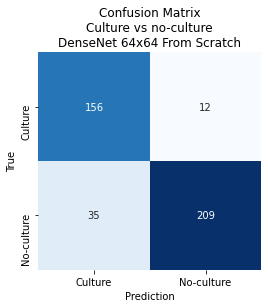

In [82]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Culture','final_spacv_10FOLD_culture_1'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                     labels=['Culture', 'No-culture'],
                     title="Confusion Matrix\nCulture vs no-culture\nDenseNet 64x64 From Scratch")

### DenseNet 64x64 Fine tuning

1/1 [==============================] - 4s 4s/step - loss: 1.8889 - accuracy: 0.8786 - precision: 0.9254 - recall: 0.8648 - f1_score_keras: 0.8941
Mean accuracy : 0.8587378621101379
Stdev accuracy : 0.04271845763380089


Mean loss : 1.209312343597412
Stdev loss : 0.49388789420736096


Mean precision : 0.8834498167037964
Stdev precision : 0.07305642768126501


Mean recall : 0.8885245680809021
Stdev recall : 0.027723822942130237


Mean f1-score : 0.8831860184669494
Stdev f1-score : 0.027564607466183114
Macro F1-Score : 0.8905631218004443


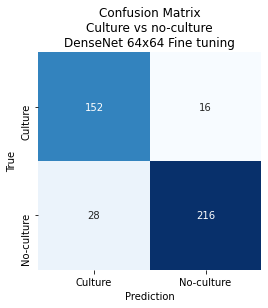

In [83]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Culture','final_spacv_10FOLD_culture_finetuning_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                     labels=['Culture', 'No-culture'],
                     title="Confusion Matrix\nCulture vs no-culture\nDenseNet 64x64 Fine tuning")

# Spatial cross val Multilabel (coffee / culture)

In [84]:
paths = {
    'DenseNet 64x64 coffee-culture':os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_3', 'final_spacv_10FOLD_multilabel_3.json'),
}

In [85]:
epochs_accs = []
epochs_f1 = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        metrics = list(zip(*data))
        
        epochs_loss.append(metrics[0])
        epochs_accs.append(metrics[1])

        if len(metrics) > 4:
            epochs_f1.append(metrics[4])
        else:
            tmp = []
            for i in range(0,len(metrics[2])):
                tmp.append(2*((metrics[2][i]*metrics[3][i]) / (metrics[2][i]+metrics[3][i])))
            epochs_f1.append(tmp)
        


### Boxplot

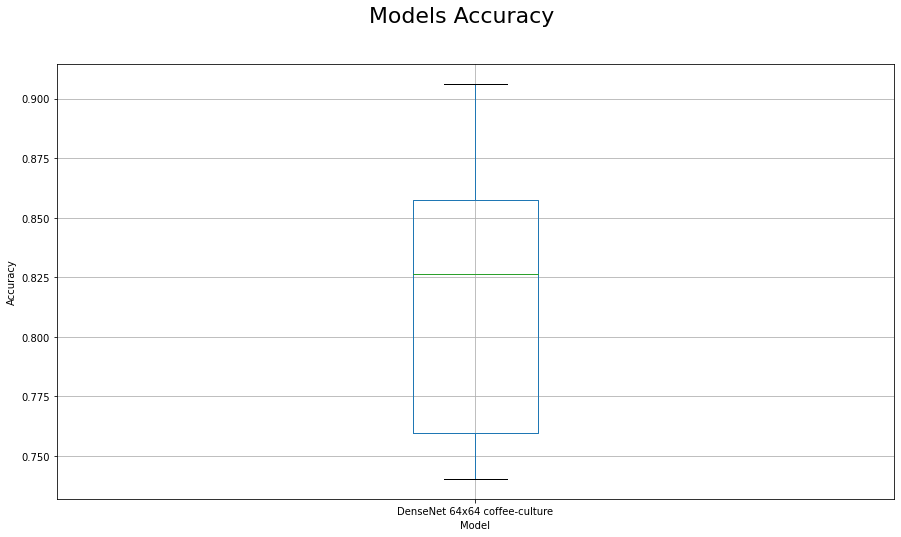

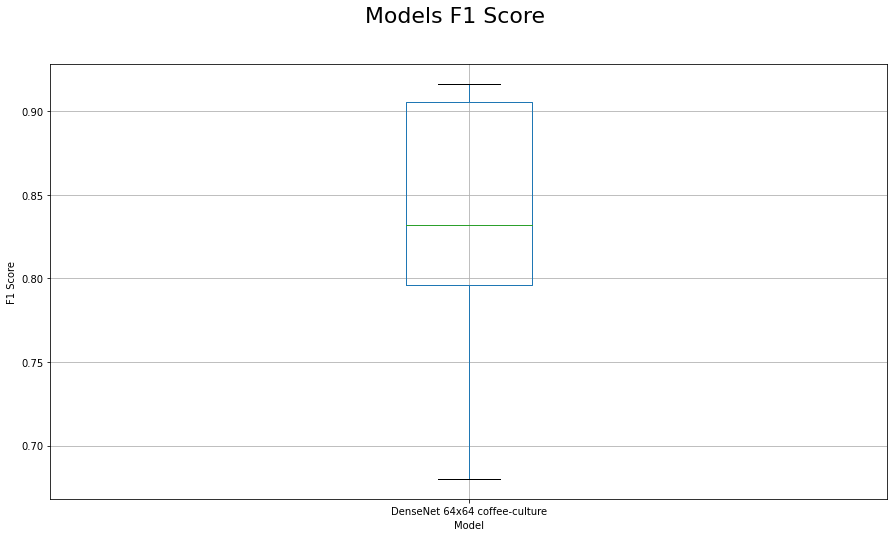

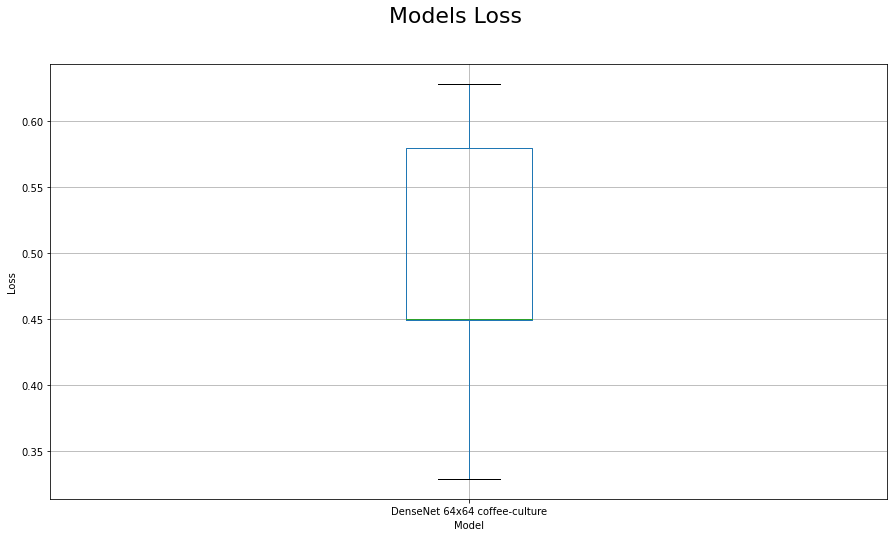

In [86]:
dict_metrics = {'Accuracy':epochs_accs, 'F1 Score':epochs_f1, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric}", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

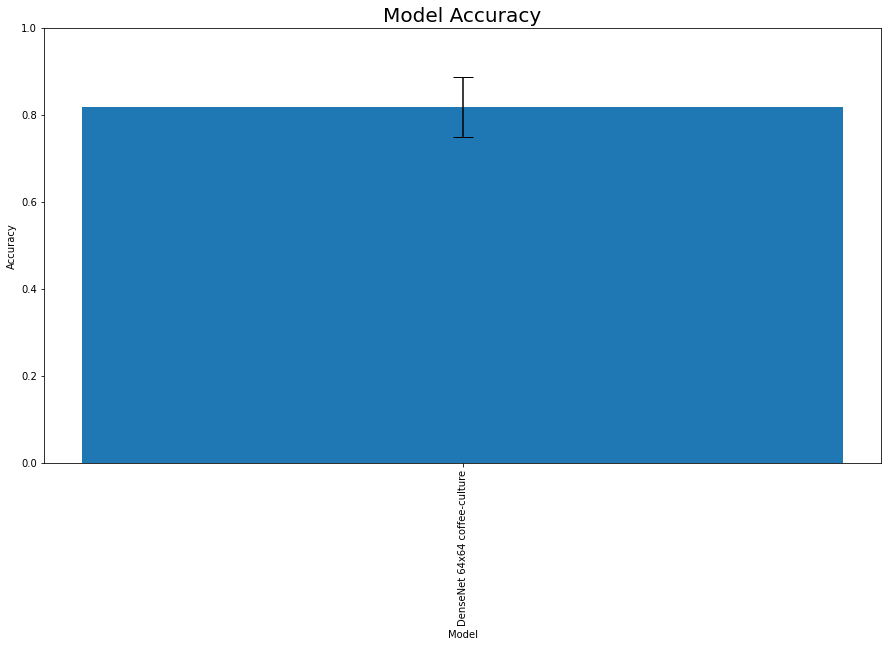

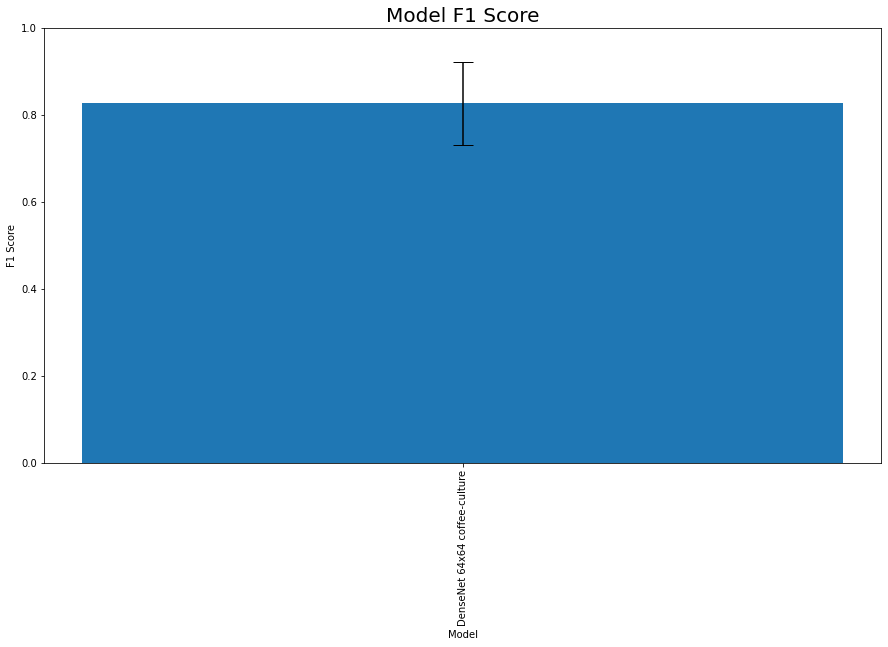

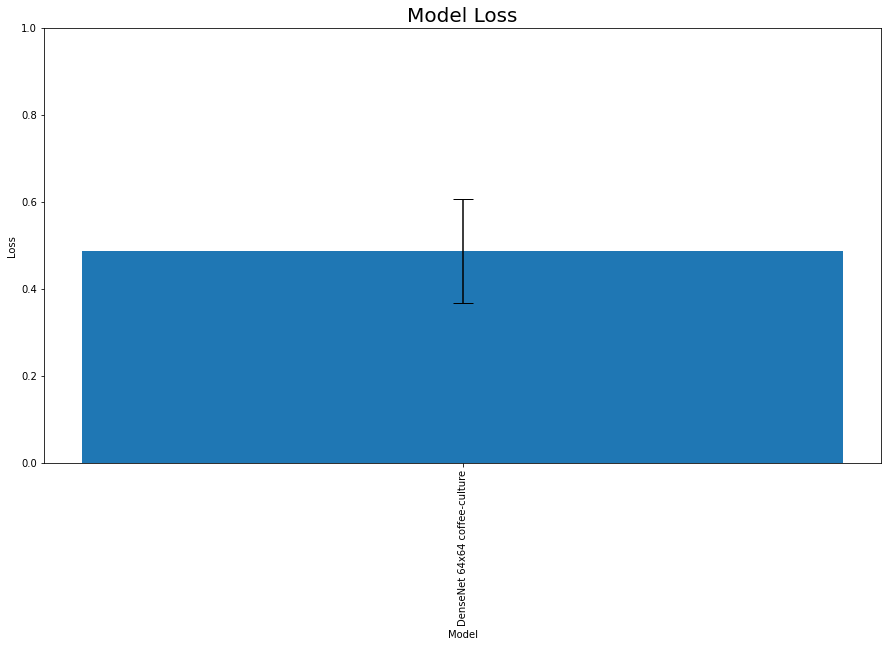

In [87]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [94]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'culture_coffee_10fold','test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

In [89]:
def set_model_prediction_multi_label(model_path, test_set, custom_objects, with_f1=False):
    test_generator =  generator(test_set['path'].to_numpy(), 
                            test_set[['label_culture','label_coffee']].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(test_set))
    
    prediction_set = []
    evaluate = []
    
    X, y = next(test_generator)
    
    for path in os.listdir(model_path):
        if path.split(".")[1] == 'h5':
            restored_model = None
            if with_f1:
                restored_model = load_model(os.path.join(model_path, path), custom_objects, compile=False)
                restored_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',metrics=[metrics.BinaryAccuracy(name='accuracy'),metrics.Precision(name='precision'),metrics.Recall(name='recall'),f1_score_keras])
            else : 
                restored_model = load_model(os.path.join(model_path, path), custom_objects)
            
            evaluate.append(restored_model.evaluate(test_generator, steps=1))
            prediction_set.append(np.where(restored_model.predict(X) > 0.5, 1, 0))
            
    predictions = []
    for pred in zip(*prediction_set):
        culture_pred, coffee_pred = zip(*pred)

        predictions.append(np.array([np.argmax(np.bincount(culture_pred)),
                                    np.argmax(np.bincount(coffee_pred))]))
    
    cm = multilabel_confusion_matrix(y, predictions)
    
    plot_confusion_matrix(cm[0], ["Culture", "No-Culture"],"Confusion Matrix\nCulture vs No-Culture\nDenseNet 64x64")
    plot_confusion_matrix(cm[1], ["Coffee", "Other"],"Confusion Matrix\nCoffee vs other\nDenseNet 64x64")
    
    if with_f1:
        losses, accs, precisions, recalls, f1 = zip(*evaluate)
    else :
        losses, accs, precisions, recalls = zip(*evaluate)

    print("Global metrics")
    print(f"Mean accuracy : {np.mean(accs)}")
    print(f"Stdev accuracy : {np.std(accs)}")
    print("\n")
    print(f"Mean loss : {np.mean(losses)}")
    print(f"Stdev loss : {np.std(losses)}")
    print("\n")
    print(f"Mean precision : {np.mean(precisions)}")
    print(f"Stdev precision : {np.std(precisions)}")
    print("\n")
    print(f"Mean recall : {np.mean(recalls)}")
    print(f"Stdev recall : {np.std(recalls)}")
    print("\n")
    if with_f1:
        print(f"Mean f1-score : {np.mean(f1)}")
        print(f"Stdev f1-score : {np.std(f1)}")
    else:
        print(f"F1-Score : {f1_score(y, predictions)}")
    print("\n")
    culture_pred, coffee_pred = zip(*predictions)
    culture_true, coffee_true = zip(*y)
    print("Culture vs no-culture")
    print(f"F1-Score : {f1_score(culture_true, culture_pred)}")
    print(f"Macro F1-Score : {f1_score(culture_true, culture_pred, average='macro')}")
    print("Coffee vs other")
    print(f"F1-Score : {f1_score(coffee_true, coffee_pred)}")
    print(f"Macro F1-Score : {f1_score(coffee_true, coffee_pred, average='macro')}")

### DenseNet 64x64 

1/1 [==============================] - 4s 4s/step - loss: 0.7000 - accuracy: 0.7535 - precision: 0.8241 - recall: 0.7463 - f1_score_keras: 0.7833
Global metrics
Mean accuracy : 0.6873239517211914
Stdev accuracy : 0.03650103342215706


Mean loss : 0.8421413421630859
Stdev loss : 0.0865966994281722


Mean precision : 0.7280656337738037
Stdev precision : 0.05026572049197425


Mean recall : 0.7687315702438354
Stdev recall : 0.012459418028349158


Mean f1-score : 0.7466243028640747
Stdev f1-score : 0.020924717955915526


Culture vs no-culture
F1-Score : 0.5491803278688525
Macro F1-Score : 0.6048370775146732
Coffee vs other
F1-Score : 0.8466522678185745
Macro F1-Score : 0.5852308958140491


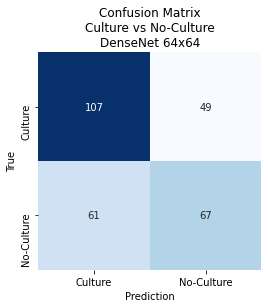

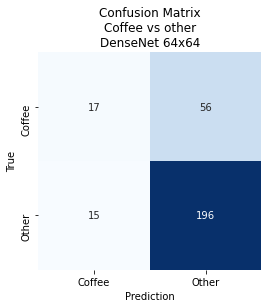

In [92]:
set_model_prediction_multi_label(os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_3'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True)

1/1 [==============================] - 4s 4s/step - loss: 0.3008 - accuracy: 0.8873 - precision: 0.7952 - recall: 0.9384 - f1_score_keras: 0.8609
Global metrics
Mean accuracy : 0.88591548204422
Stdev accuracy : 0.013700758651796804


Mean loss : 0.3525685429573059
Stdev loss : 0.06699511027747623


Mean precision : 0.7988333463668823
Stdev precision : 0.04972997849470382


Mean recall : 0.9374407649040222
Stdev recall : 0.05142997846782961


Mean f1-score : 0.8596940636634827
Stdev f1-score : 0.009170551480590523


Culture vs no-culture
F1-Score : 0.0
Macro F1-Score : 1.0
Coffee vs other
F1-Score : 0.8639308855291576
Macro F1-Score : 0.6319654427645788


/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


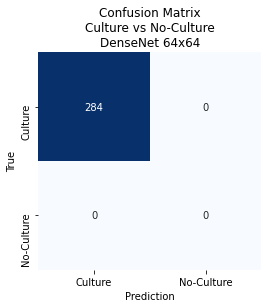

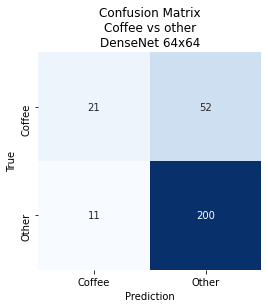

In [93]:
data_test['label_culture'] = 0
set_model_prediction_multi_label(os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_culture_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True)

1/1 [==============================] - 4s 4s/step - loss: 0.4984 - accuracy: 0.8838 - precision: 0.9559 - recall: 0.5078 - f1_score_keras: 0.6633
Global metrics
Mean accuracy : 0.8461267590522766
Stdev accuracy : 0.023132499213065393


Mean loss : 0.5626310765743255
Stdev loss : 0.05966378074690336


Mean precision : 0.7309015035629273
Stdev precision : 0.12513795047541285


Mean recall : 0.5390625
Stdev recall : 0.019136638615493577


Mean f1-score : 0.6145176887512207
Stdev f1-score : 0.02961050845943306


Culture vs no-culture
F1-Score : 0.6188340807174888
Macro F1-Score : 0.686228634561643
Coffee vs other
F1-Score : 0.0
Macro F1-Score : 1.0


/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


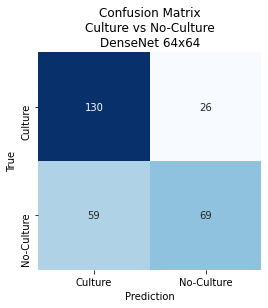

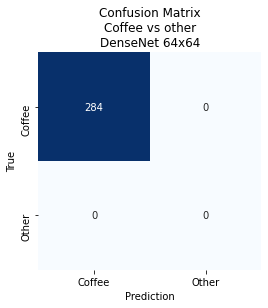

In [95]:
data_test['label_coffee'] = 0
set_model_prediction_multi_label(os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_coffee_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True)

# Spatial cross val loss/acc
## Classic spatial cross val

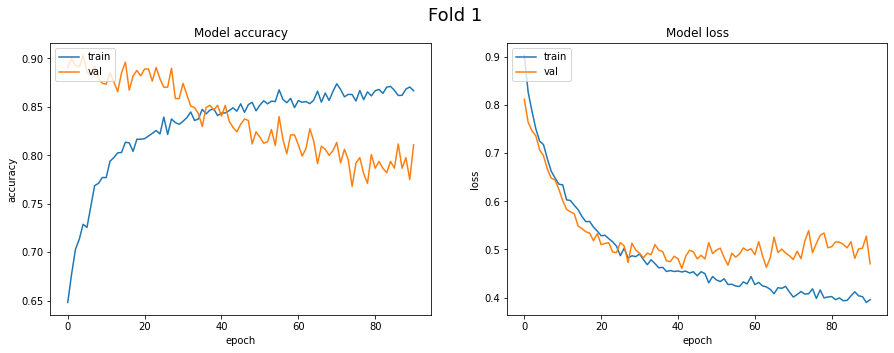

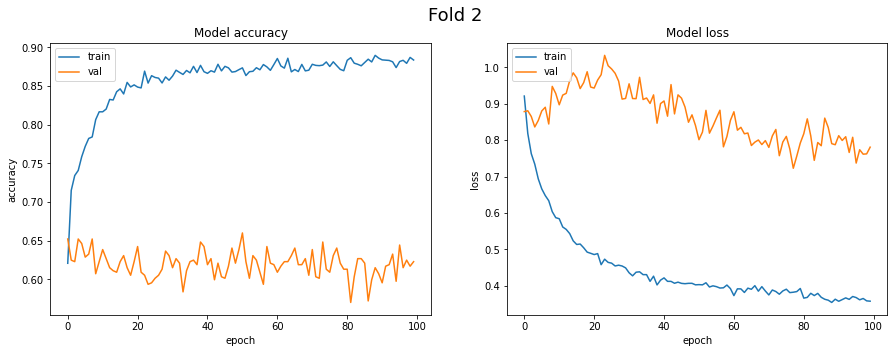

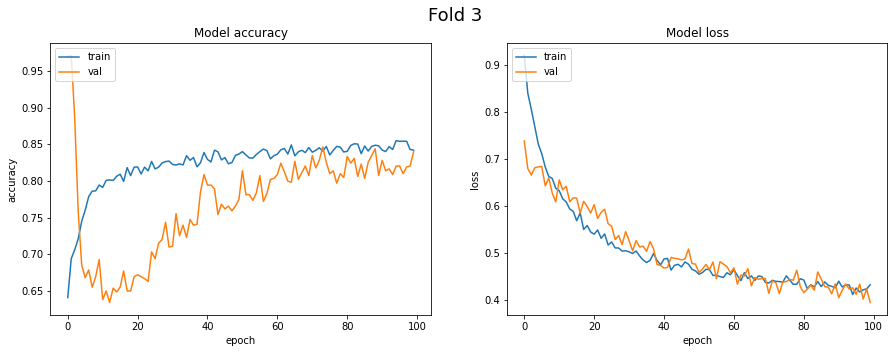

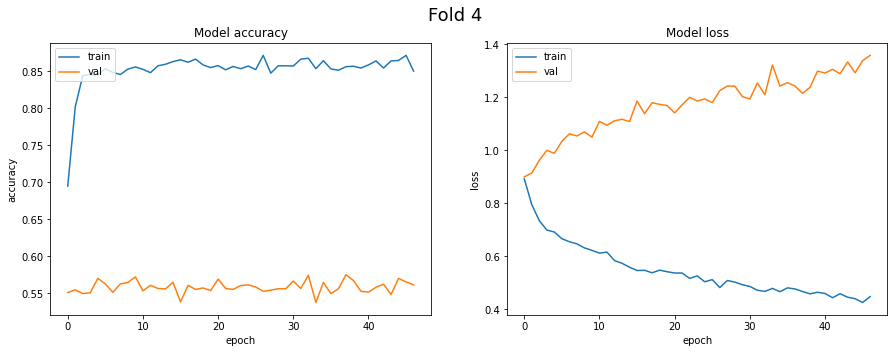

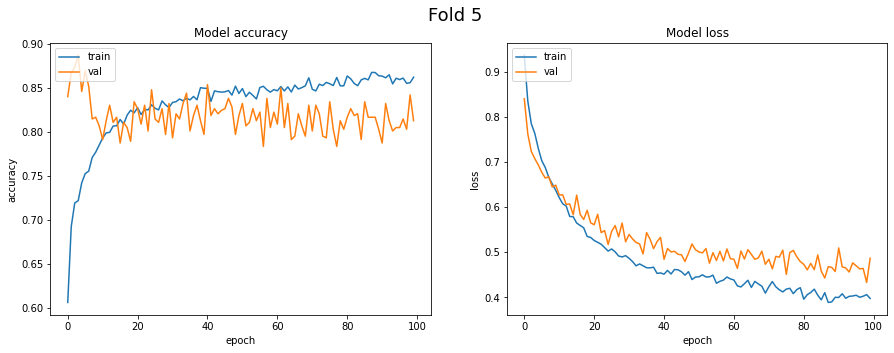

In [24]:
BASE_PATH = os.path.join("saved_models", "transfer_learning", "Coffee")

folder = os.path.join(BASE_PATH, "spacv_coffee_1")

i = 0

for p in os.listdir(folder):
    if p.split(".")[1] == 'npy':
        rest_hist = np.load(os.path.join(folder, p), allow_pickle=True).item()
        
        fig, axes = plt.subplots(1,2,figsize=(15,5))
        # summarize history for accuracy
        axes[0].plot(rest_hist['accuracy'])
        axes[0].plot(rest_hist['val_accuracy'])
        axes[0].set_title('Model accuracy')
        axes[0].set_ylabel('accuracy')
        axes[0].set_xlabel('epoch')
        axes[0].legend(['train', 'val'], loc='upper left')

        # summarize history for loss
        axes[1].plot(rest_hist['loss'])
        axes[1].plot(rest_hist['val_loss'])
        axes[1].set_title('Model loss')
        axes[1].set_ylabel('loss')
        axes[1].set_xlabel('epoch')
        axes[1].legend(['train', 'val'], loc='upper left')
        
        fig.suptitle(f"Fold {i+1}", fontsize=18)
        i+=1
        

## Spatial cross val stratified

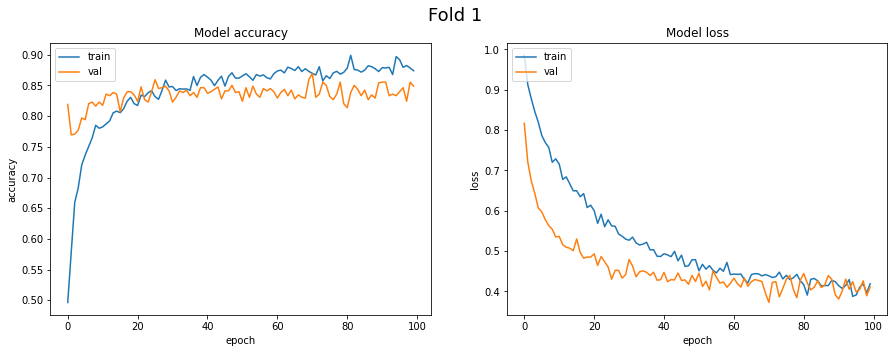

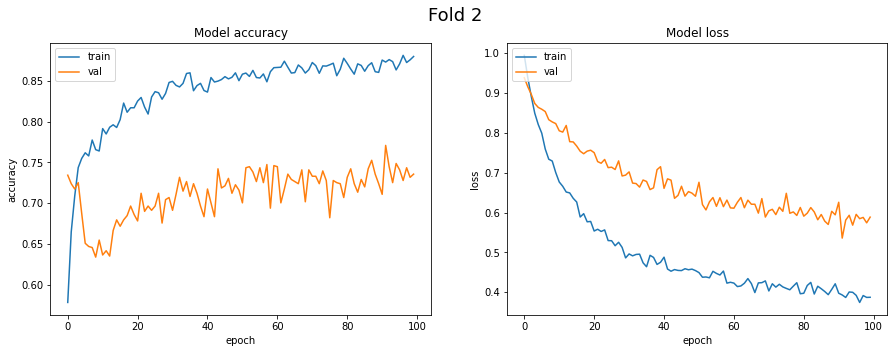

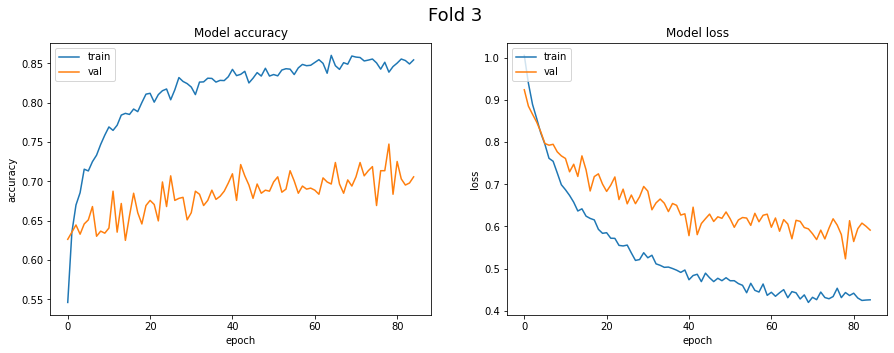

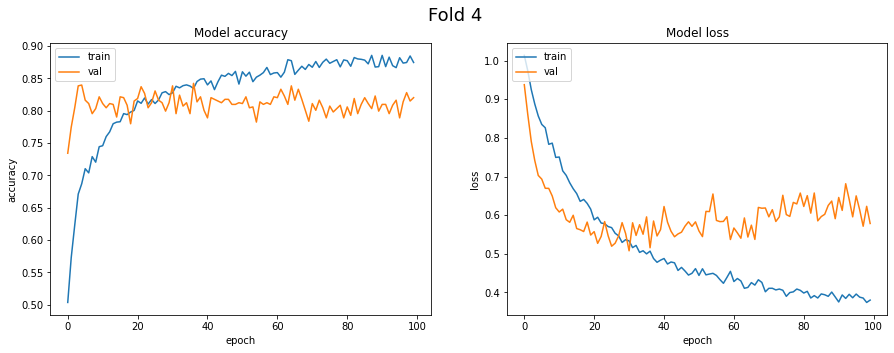

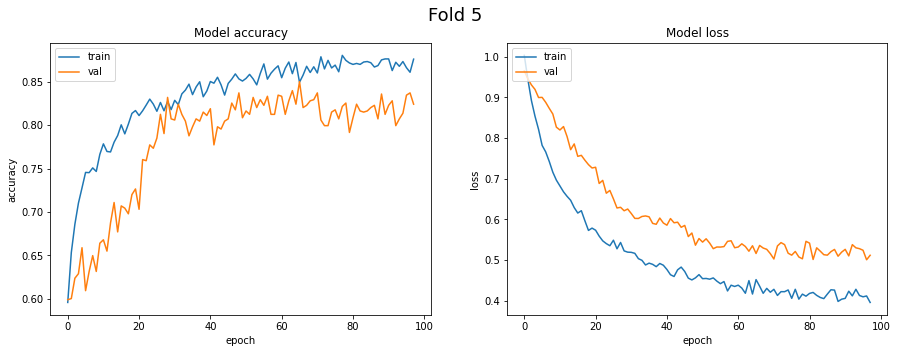

In [25]:
BASE_PATH = os.path.join("saved_models", "transfer_learning", "Coffee")

folder = os.path.join(BASE_PATH, "strat_spacv_coffee_1")

i = 0

for p in os.listdir(folder):
    if p.split(".")[1] == 'npy':
        rest_hist = np.load(os.path.join(folder, p), allow_pickle=True).item()
        
        fig, axes = plt.subplots(1,2,figsize=(15,5))
        # summarize history for accuracy
        axes[0].plot(rest_hist['accuracy'])
        axes[0].plot(rest_hist['val_accuracy'])
        axes[0].set_title('Model accuracy')
        axes[0].set_ylabel('accuracy')
        axes[0].set_xlabel('epoch')
        axes[0].legend(['train', 'val'], loc='upper left')

        # summarize history for loss
        axes[1].plot(rest_hist['loss'])
        axes[1].plot(rest_hist['val_loss'])
        axes[1].set_title('Model loss')
        axes[1].set_ylabel('loss')
        axes[1].set_xlabel('epoch')
        axes[1].legend(['train', 'val'], loc='upper left')
        
        fig.suptitle(f"Fold {i+1}", fontsize=18)
        i+=1
        

## Spatial cross val by class

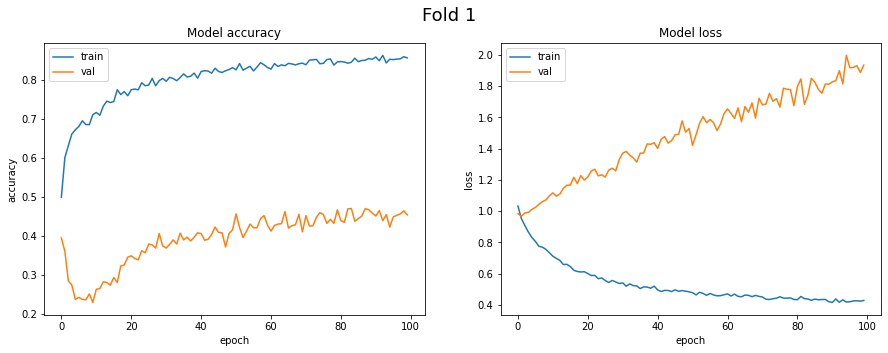

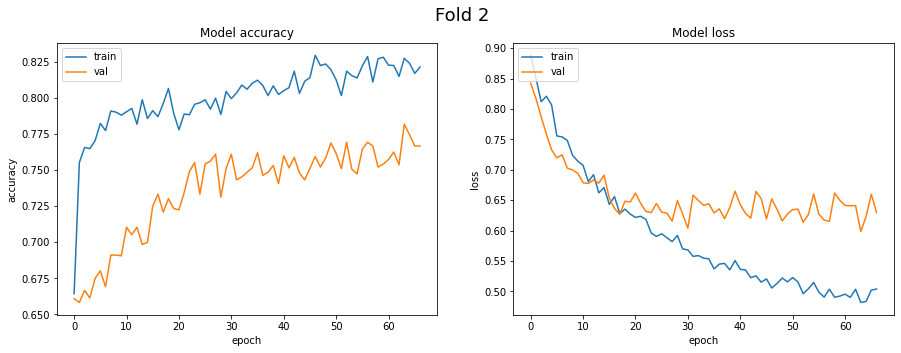

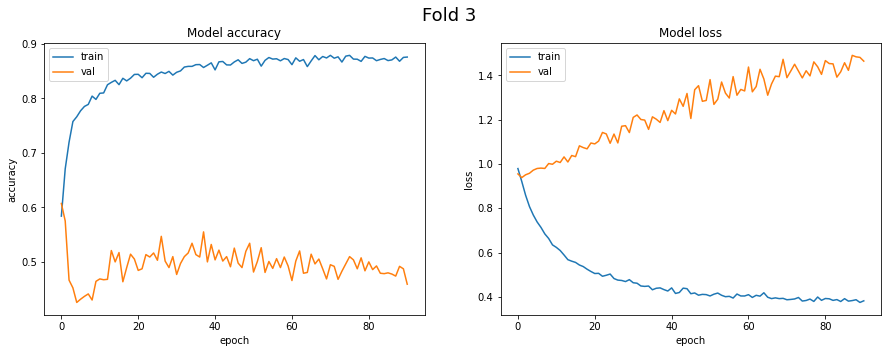

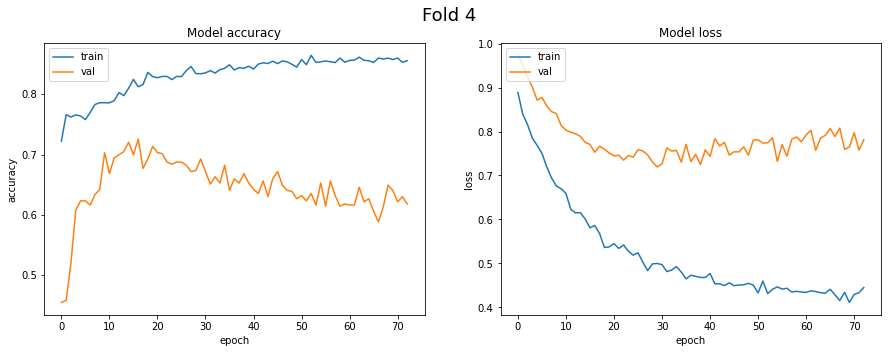

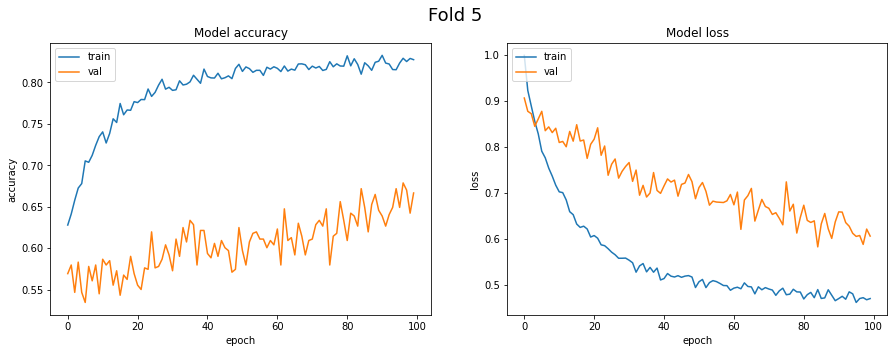

In [26]:
BASE_PATH = os.path.join("saved_models", "transfer_learning", "Coffee")

folder = os.path.join(BASE_PATH, "class_spacv_coffee_1")

i = 0

for p in os.listdir(folder):
    if p.split(".")[1] == 'npy':
        rest_hist = np.load(os.path.join(folder, p), allow_pickle=True).item()
        
        fig, axes = plt.subplots(1,2,figsize=(15,5))
        # summarize history for accuracy
        axes[0].plot(rest_hist['accuracy'])
        axes[0].plot(rest_hist['val_accuracy'])
        axes[0].set_title('Model accuracy')
        axes[0].set_ylabel('accuracy')
        axes[0].set_xlabel('epoch')
        axes[0].legend(['train', 'val'], loc='upper left')

        # summarize history for loss
        axes[1].plot(rest_hist['loss'])
        axes[1].plot(rest_hist['val_loss'])
        axes[1].set_title('Model loss')
        axes[1].set_ylabel('loss')
        axes[1].set_xlabel('epoch')
        axes[1].legend(['train', 'val'], loc='upper left')
        
        fig.suptitle(f"Fold {i+1}", fontsize=18)
        i+=1
        

## Spatial cross val by class (10 fold /2)

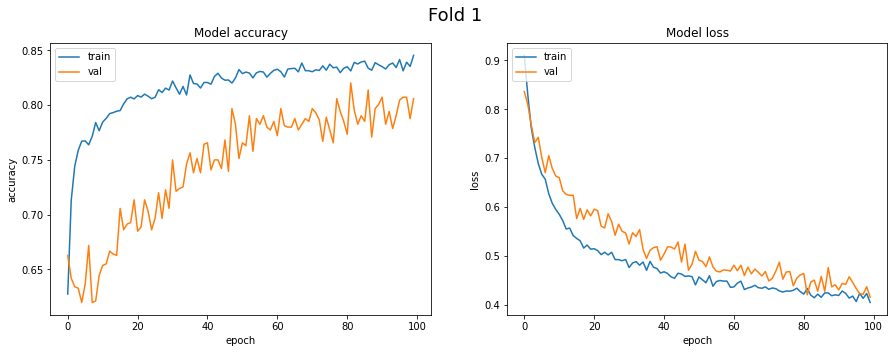

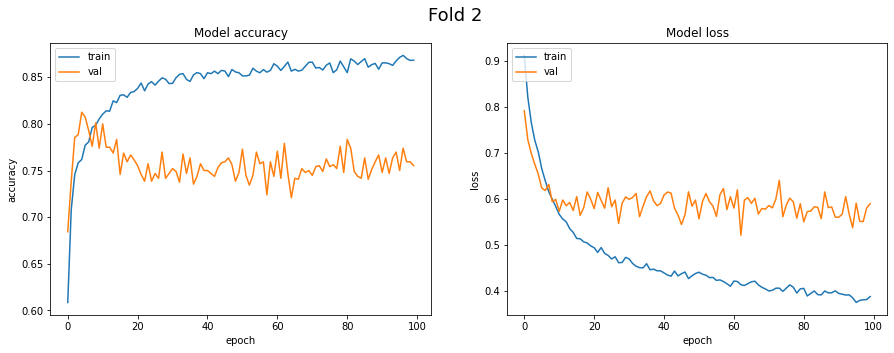

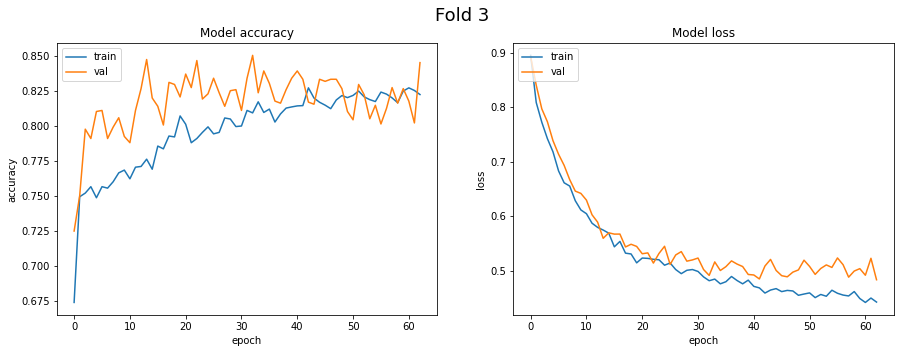

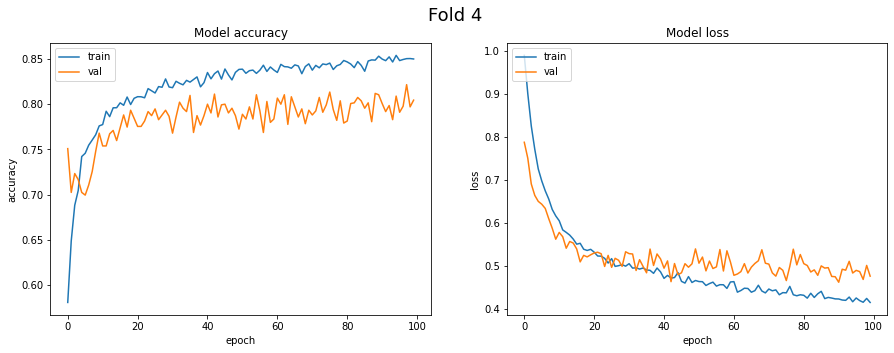

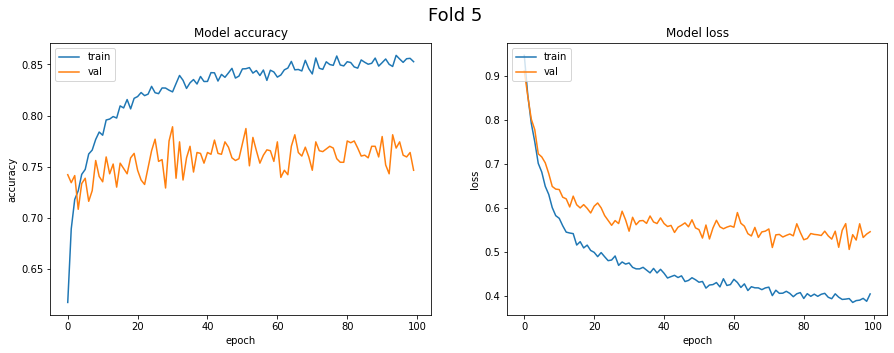

In [27]:
BASE_PATH = os.path.join("saved_models", "transfer_learning", "Coffee")

folder = os.path.join(BASE_PATH, "spacv_10FOLD_coffee_1")

i = 0

for p in os.listdir(folder):
    if p.split(".")[1] == 'npy':
        rest_hist = np.load(os.path.join(folder, p), allow_pickle=True).item()
        
        fig, axes = plt.subplots(1,2,figsize=(15,5))
        # summarize history for accuracy
        axes[0].plot(rest_hist['accuracy'])
        axes[0].plot(rest_hist['val_accuracy'])
        axes[0].set_title('Model accuracy')
        axes[0].set_ylabel('accuracy')
        axes[0].set_xlabel('epoch')
        axes[0].legend(['train', 'val'], loc='upper left')

        # summarize history for loss
        axes[1].plot(rest_hist['loss'])
        axes[1].plot(rest_hist['val_loss'])
        axes[1].set_title('Model loss')
        axes[1].set_ylabel('loss')
        axes[1].set_xlabel('epoch')
        axes[1].legend(['train', 'val'], loc='upper left')
        
        fig.suptitle(f"Fold {i+1}", fontsize=18)
        i+=1
        

## Spatial cross val by class (10 fold /2) 32x32

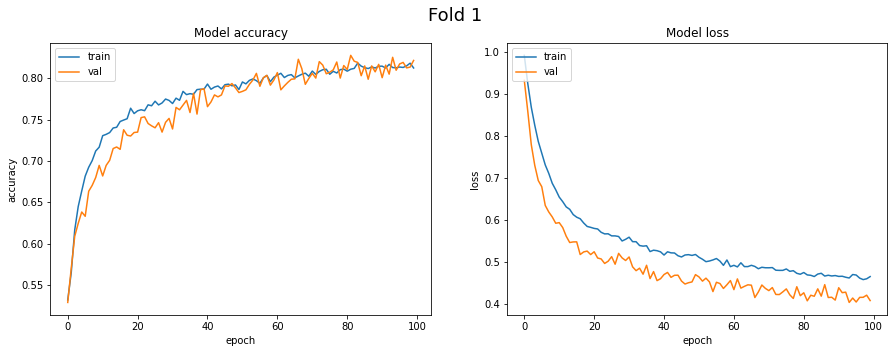

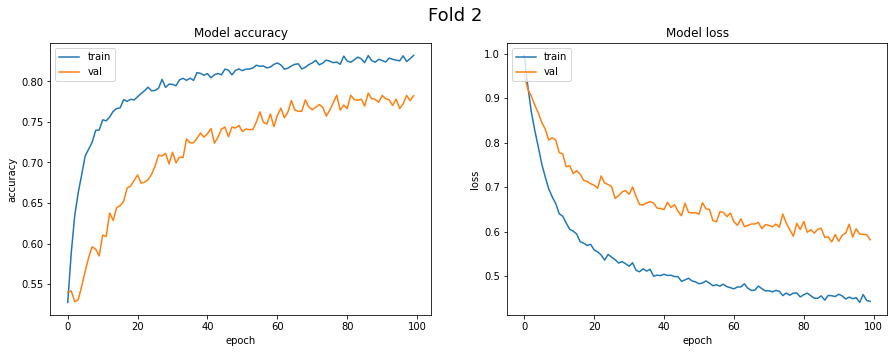

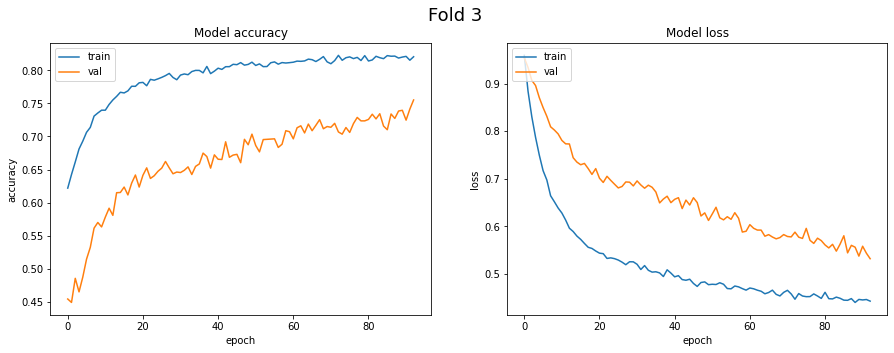

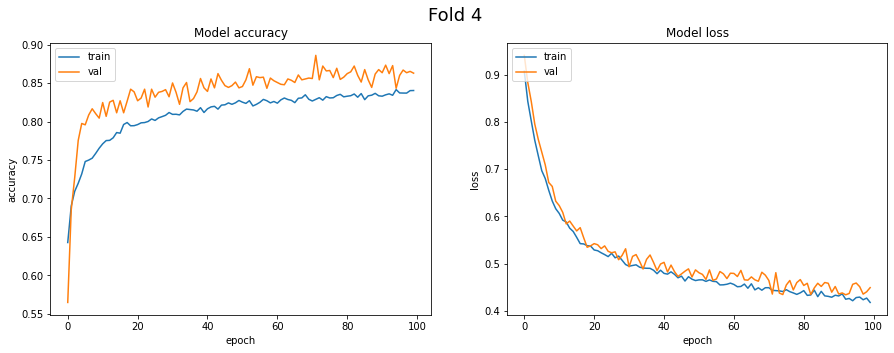

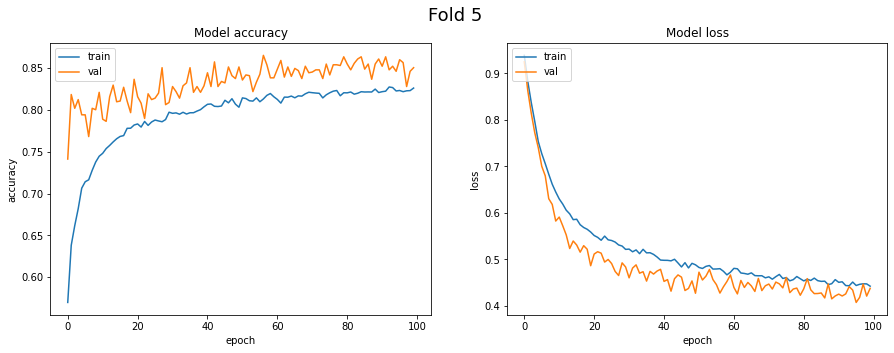

In [3]:
BASE_PATH = os.path.join("saved_models", "transfer_learning", "Coffee")

folder = os.path.join(BASE_PATH, "spacv_10FOLD_coffee_32_1")

i = 0

for p in os.listdir(folder):
    if p.split(".")[1] == 'npy':
        rest_hist = np.load(os.path.join(folder, p), allow_pickle=True).item()
        
        fig, axes = plt.subplots(1,2,figsize=(15,5))
        # summarize history for accuracy
        axes[0].plot(rest_hist['accuracy'])
        axes[0].plot(rest_hist['val_accuracy'])
        axes[0].set_title('Model accuracy')
        axes[0].set_ylabel('accuracy')
        axes[0].set_xlabel('epoch')
        axes[0].legend(['train', 'val'], loc='upper left')

        # summarize history for loss
        axes[1].plot(rest_hist['loss'])
        axes[1].plot(rest_hist['val_loss'])
        axes[1].set_title('Model loss')
        axes[1].set_ylabel('loss')
        axes[1].set_xlabel('epoch')
        axes[1].legend(['train', 'val'], loc='upper left')
        
        fig.suptitle(f"Fold {i+1}", fontsize=18)
        i+=1
        

# Transfer learning DenseNet model

## Performance 64x64 vs 32x32 - All year dataset
### Coffee

In [42]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, 'transfer_learning','Coffee','32x32transfer', '32x32transfer.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'transfer_learning','Coffee','cross_val_coffee_1', 'cross_val_coffee_1_2.npy'),allow_pickle='TRUE').item()

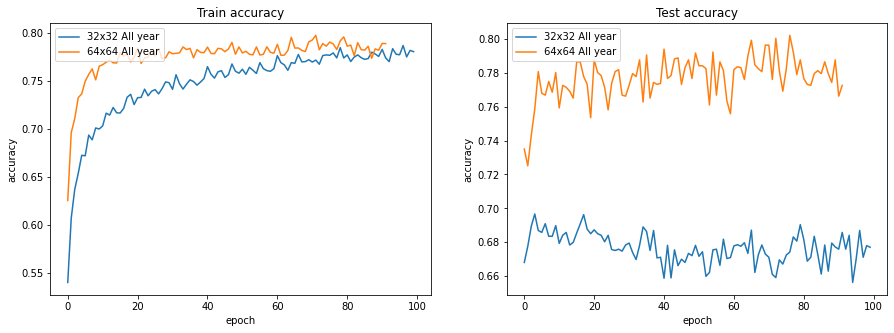

In [43]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32 All year', '64x64 All year'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32 All year', '64x64 All year'], loc='upper left')

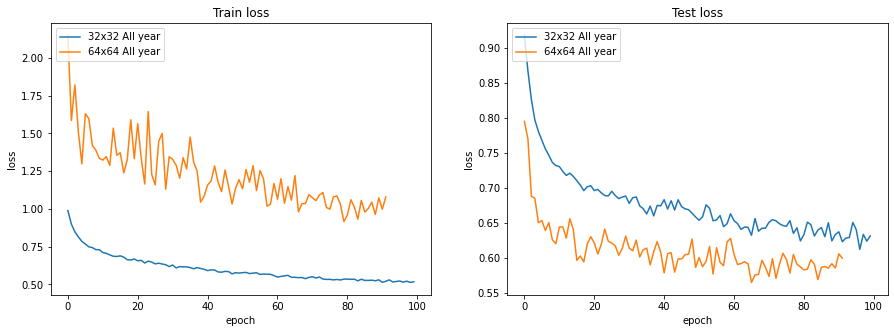

In [44]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32 All year', '64x64 All year'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32 All year', '64x64 All year'], loc='upper left')

### Culture vs no culture

In [6]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, 'transfer_learning','Culture','32x32transfer_culture', '32x32transfer_culture.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'transfer_learning','Culture','transfer_learning_culture2', 'transfer_learning_culture2.npy'),allow_pickle='TRUE').item()

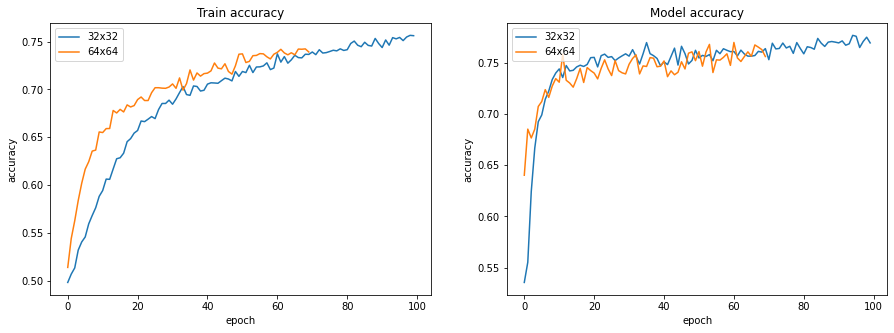

In [7]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32 All year', '64x64 All year'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32 All year', '64x64 All year'], loc='upper left')

Text(0.5, 0, 'epoch')

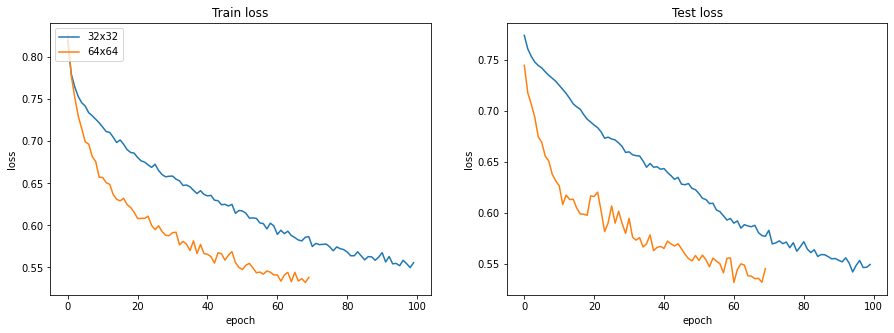

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32 All year', '64x64 All year'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32 All year', '64x64 All year'], loc='upper left')

# Band variation model - DenseNet201
## 3 bands 

In [50]:
history_13bands = np.load(os.path.join(SAVED_MODELS_PATH, 'band_variation','Coffee','band_variation3_13bands_1', 'band_variation3_13bands_1.npy'),allow_pickle='TRUE').item()
history_rgb_swir_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'band_variation','Coffee','band_variation3_RGB_SWIR_1', 'band_variation3_RGB_SWIR_1.npy'),allow_pickle='TRUE').item()
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'band_variation','Coffee','band_variation3_highres_1', 'band_variation3_highres_1.npy'),allow_pickle='TRUE').item()
history_transfer_learning = np.load(os.path.join('saved_models','transfer_learning', 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

13 bands test accuracy : 0.4865364134311676
High res test accuracy : 0.47848957777023315
RGB + SWIR test accuracy : 0.6016015410423279
Original model test accuracy : 0.71833336353302


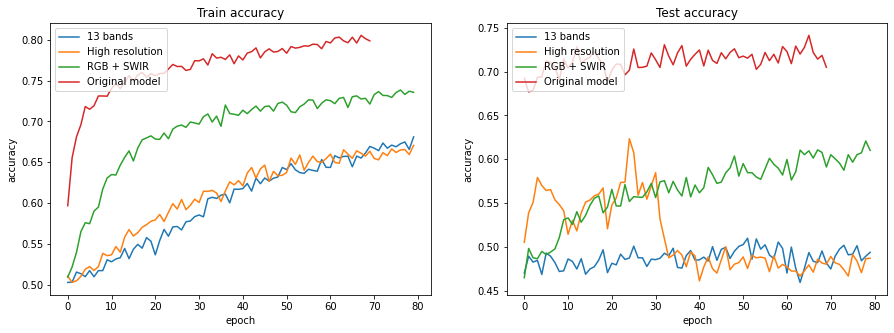

In [52]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_13bands['accuracy'])
axes[0].plot(history_highres_bands['accuracy'])
axes[0].plot(history_rgb_swir_bands['accuracy'])
axes[0].plot(history_transfer_learning['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands', 'High resolution', 'RGB + SWIR','Original model'], loc='upper left')

axes[1].plot(history_13bands['val_accuracy'])
axes[1].plot(history_highres_bands['val_accuracy'])
axes[1].plot(history_rgb_swir_bands['val_accuracy'])
axes[1].plot(history_transfer_learning['val_accuracy'])
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['13 bands', 'High resolution', 'RGB + SWIR', 'Original model'], loc='upper left')

print(f"13 bands test accuracy : {np.mean(history_13bands['val_accuracy'][-20:])}")
print(f"High res test accuracy : {np.mean(history_highres_bands['val_accuracy'][-20:])}")
print(f"RGB + SWIR test accuracy : {np.mean(history_rgb_swir_bands['val_accuracy'][-20:])}")
print(f"Original model test accuracy : {np.mean(history_transfer_learning['val_accuracy'][-20:])}")

13 bands test loss : 1.0146326931317649
High res test loss : 0.8543806447585425
RGB + SWIR test loss : 0.7041762778162955
Original model test loss : 0.702540054048101


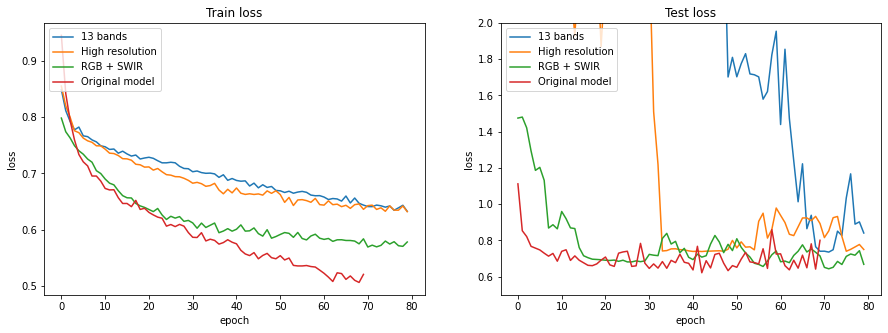

In [53]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_13bands['loss'])
axes[0].plot(history_highres_bands['loss'])
axes[0].plot(history_rgb_swir_bands['loss'])
axes[0].plot(history_transfer_learning['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands', 'High resolution', 'RGB + SWIR', 'Original model'], loc='upper left')

axes[1].plot(history_13bands['val_loss'])
axes[1].plot(history_highres_bands['val_loss'])
axes[1].plot(history_rgb_swir_bands['val_loss'])
axes[1].plot(history_transfer_learning['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0.5,2])
axes[1].legend(['13 bands', 'High resolution', 'RGB + SWIR', 'Original model'], loc='upper left')

print(f"13 bands test loss : {np.mean(history_13bands['val_loss'][-20:])}")
print(f"High res test loss : {np.mean(history_highres_bands['val_loss'][-20:])}")
print(f"RGB + SWIR test loss : {np.mean(history_rgb_swir_bands['val_loss'][-20:])}")
print(f"Original model test loss : {np.mean(history_transfer_learning['val_loss'][-20:])}")

## 13 bands model

In [54]:
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH,'band_variation', 'Coffee','band_variation13_highres', 'band_variation13_highres.npy'),allow_pickle='TRUE').item()
history_rgb_swir_bands = np.load(os.path.join(SAVED_MODELS_PATH,'band_variation',  'Coffee','band_variation13_RGB_SWR', 'band_variation13_RGB_SWR.npy'),allow_pickle='TRUE').item()
history_transfer_learning = np.load(os.path.join('saved_models','transfer_learning', 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

High res test accuracy : 0.5473177433013916
RGB + SWIR test accuracy : 0.6244140863418579
Original model test accuracy : 0.71833336353302


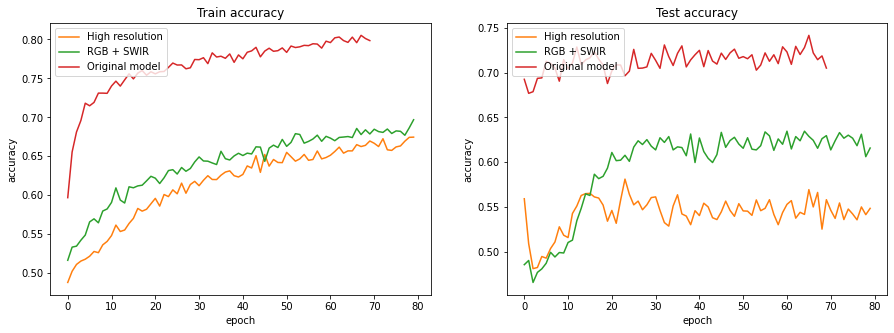

In [56]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_highres_bands['accuracy'], color='tab:orange')
axes[0].plot(history_rgb_swir_bands['accuracy'], color='tab:green')
axes[0].plot(history_transfer_learning['accuracy'], color='tab:red')
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['High resolution','RGB + SWIR', 'Original model'], loc='upper left')

axes[1].plot(history_highres_bands['val_accuracy'], color='tab:orange')
axes[1].plot(history_rgb_swir_bands['val_accuracy'], color='tab:green')
axes[1].plot(history_transfer_learning['val_accuracy'], color='tab:red')
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['High resolution','RGB + SWIR', 'Original model'], loc='upper left')

print(f"High res test accuracy : {np.mean(history_highres_bands['val_accuracy'][-20:])}")
print(f"RGB + SWIR test accuracy : {np.mean(history_rgb_swir_bands['val_accuracy'][-20:])}")
print(f"Original model test accuracy : {np.mean(history_transfer_learning['val_accuracy'][-20:])}")

High res test loss : 0.7385803946355978
RGB + SWIR test loss : 0.7478472946584225
Original model test loss : 0.702540054048101


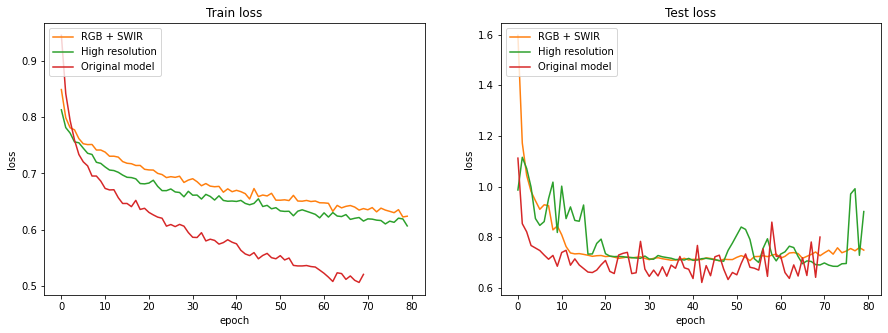

In [57]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_highres_bands['loss'], color='tab:orange')
axes[0].plot(history_rgb_swir_bands['loss'], color='tab:green')
axes[0].plot(history_transfer_learning['loss'], color='tab:red')
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['RGB + SWIR', 'High resolution', 'Original model'], loc='upper left')

axes[1].plot(history_highres_bands['val_loss'], color='tab:orange')
axes[1].plot(history_rgb_swir_bands['val_loss'], color='tab:green')
axes[1].plot(history_transfer_learning['val_loss'], color='tab:red')
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['RGB + SWIR', 'High resolution', 'Original model'], loc='upper left')

print(f"High res test loss : {np.mean(history_highres_bands['val_loss'][-20:])}")
print(f"RGB + SWIR test loss : {np.mean(history_rgb_swir_bands['val_loss'][-20:])}")
print(f"Original model test loss : {np.mean(history_transfer_learning['val_loss'][-20:])}")